# Install required libraries
!pip install opencv-python-headless
!pip install tensorflow
!pip install matplotlib

Saving p1.bmp to p1 (5).bmp


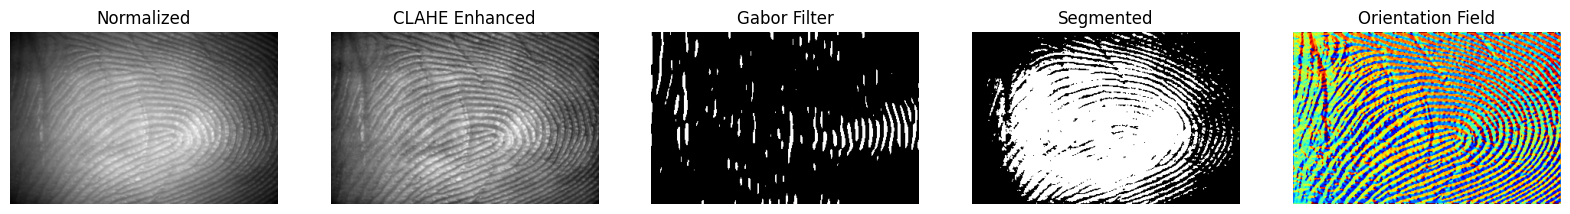

In [ ]:
colimport cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import gabor
from skimage.morphology import opening, disk
from google.colab import files

def normalize_image(image):
    """Normalize image to range [0,1]"""
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def enhance_with_clahe(image):
    """Enhance fingerprint using CLAHE"""
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(image)

def apply_gabor_filter(image, frequency=0.1):
    """Apply Gabor filter to enhance ridges"""
    filt_real, _ = gabor(image, frequency=frequency)
    return normalize_image(filt_real)

def segment_fingerprint(image):
    """Segment fingerprint using Otsu's thresholding"""
    _, segmented = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return segmented

def estimate_orientation(image):
    """Estimate ridge orientation using Sobel filter"""
    gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=5)
    gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=5)
    orientation = np.arctan2(gy, gx)
    return orientation

def preprocess_fingerprint(image_path):
    """Full preprocessing pipeline"""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    normalized = normalize_image(image)
    enhanced = enhance_with_clahe(image)
    gabor_enhanced = apply_gabor_filter(enhanced)
    segmented = segment_fingerprint(enhanced)
    orientation = estimate_orientation(enhanced)

    # Display results
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    axes[0].imshow(normalized, cmap='gray')
    axes[0].set_title("Normalized")
    axes[1].imshow(enhanced, cmap='gray')
    axes[1].set_title("CLAHE Enhanced")
    axes[2].imshow(gabor_enhanced, cmap='gray')
    axes[2].set_title("Gabor Filter")
    axes[3].imshow(segmented, cmap='gray')
    axes[3].set_title("Segmented")
    axes[4].imshow(orientation, cmap='jet')
    axes[4].set_title("Orientation Field")

    for ax in axes:
        ax.axis("off")
    plt.show()

# Upload image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
preprocess_fingerprint(image_path)


In [ ]:
# Step 1: Install necessary libraries
!pip install opencv-python-headless

# Step 2: Import libraries
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Step 3: Define the image path
image_path = '/content/p1.bmp'  # Replace with your image path

Original Image


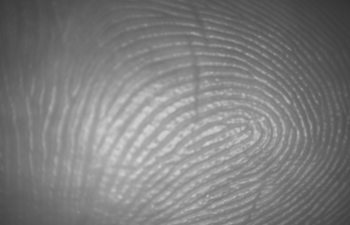

CLAHE Applied Image


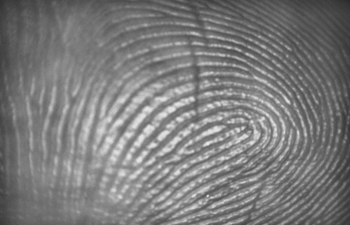

CLAHE applied image saved to /content/clahe_output.png


In [ ]:

# Step 4: Read the image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image was loaded successfully
if image is None:
    print("Error: Image not found or path is incorrect.")
else:
    # Step 5: Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)

    # Step 6: Display the original and CLAHE applied images
    print("Original Image")
    cv2_imshow(image)

    print("CLAHE Applied Image")
    cv2_imshow(clahe_image)

    # Step 7: Save the CLAHE applied image
    output_path = '/content/clahe_output.png'  # Output path
    cv2.imwrite(output_path, clahe_image)
    print(f"CLAHE applied image saved to {output_path}")

CLAHE Applied Image


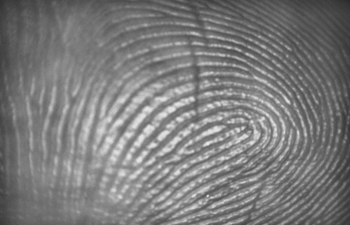

Smoothed Image (Bilateral Filter)


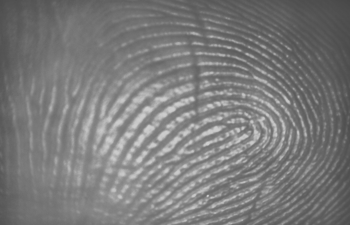

Smoothed image saved to /content/smoothed_output.png


In [ ]:
smoothed_image = cv2.bilateralFilter(clahe_image, d=0, sigmaColor=20, sigmaSpace=75)
print("CLAHE Applied Image")
cv2_imshow(clahe_image)

print("Smoothed Image (Bilateral Filter)")
cv2_imshow(smoothed_image)

    # Step 8: Save the smoothed image
output_path = '/content/smoothed_output.png'  # Output path
cv2.imwrite(output_path, smoothed_image)
print(f"Smoothed image saved to {output_path}")

Gabor Filtered Image


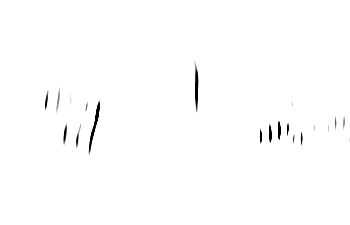

Gabor-filtered image saved to /content/gabor_output.png


In [ ]:
# Function to create a Gabor filter
def gabor_filter(image, ksize=31, sigma=4.0, theta=0, lambd=10, gamma=0.5):
    # Create Gabor kernel
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)
    # Apply the Gabor filter to the image
    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)
    return filtered_image

# Apply Gabor filter to the smoothed image
theta = 0  # Orientation of the filter (0 for horizontal ridges)
gabor_image = gabor_filter(smoothed_image, theta=np.pi * theta / 4)

# Display the Gabor-filtered image
print("Gabor Filtered Image")
cv2_imshow(gabor_image)

# Save the Gabor-filtered image
gabor_output_path = '/content/gabor_output.png'
cv2.imwrite(gabor_output_path, gabor_image)
print(f"Gabor-filtered image saved to {gabor_output_path}")



Butterworth High-Pass Filtered Image


<ipython-input-6-2ec2b6e1164f>:13: RuntimeWarning: divide by zero encountered in scalar divide
  mask[i, j] = 1 / (1 + (cutoff / dist) ** (2 * order))


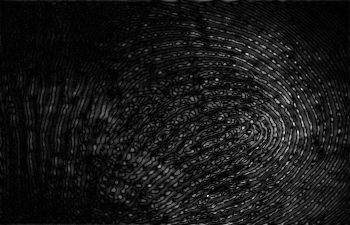

Butterworth-filtered image saved to /content/butterworth_output.png


In [ ]:
from scipy import fftpack

# Function to create a Butterworth high-pass filter
def butterworth_high_pass_filter(image, cutoff=30, order=5):
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2  # Center of the frequency domain

    # Create a mask for the high-pass filter
    mask = np.zeros((rows, cols), np.float32)
    for i in range(rows):
        for j in range(cols):
            dist = np.sqrt((i - crow) ** 2 + (j - ccol) ** 2)
            mask[i, j] = 1 / (1 + (cutoff / dist) ** (2 * order))

    # Compute the Fourier Transform of the image
    fft_image = fftpack.fft2(image)
    fft_shifted = fftpack.fftshift(fft_image)

    # Apply the mask
    fft_filtered = fft_shifted * mask

    # Inverse Fourier Transform
    ifft_shifted = fftpack.ifftshift(fft_filtered)
    ifft_image = fftpack.ifft2(ifft_shifted)
    filtered_image = np.abs(ifft_image)

    # Normalize the image
    filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return filtered_image

# Apply Butterworth high-pass filter to the smoothed image
butterworth_image = butterworth_high_pass_filter(smoothed_image, cutoff=30, order=5)

# Display the Butterworth-filtered image
print("Butterworth High-Pass Filtered Image")
cv2_imshow(butterworth_image)

# Save the Butterworth-filtered image
butterworth_output_path = '/content/butterworth_output.png'
cv2.imwrite(butterworth_output_path, butterworth_image)
print(f"Butterworth-filtered image saved to {butterworth_output_path}")

STFT-Enhanced Image


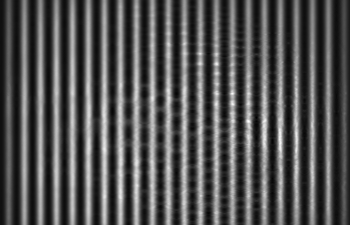

STFT-enhanced image saved to /content/stft_output.png


In [ ]:
import numpy as np
from scipy.signal import stft, istft
import cv2
from google.colab.patches import cv2_imshow

# Function to apply STFT and enhance ridges
def stft_ridge_enhancement(image, window_size=32, overlap=16):
    rows, cols = image.shape

    # Compute STFT
    f, t, Zxx = stft(image, nperseg=window_size, noverlap=overlap)

    # Enhance ridges by amplifying high-frequency components
    Zxx_enhanced = np.abs(Zxx) * (1 + np.abs(f[:, np.newaxis]))

    # Inverse STFT to reconstruct the image
    _, reconstructed_image = istft(Zxx_enhanced, nperseg=window_size, noverlap=overlap)

    # Take the real part of the reconstructed image (STFT output is complex)
    reconstructed_image = np.real(reconstructed_image)

    # Crop the image to the original size
    reconstructed_image = reconstructed_image[:rows, :cols]

    # Normalize the image to 0-255 range
    reconstructed_image = cv2.normalize(reconstructed_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    return reconstructed_image

# Apply STFT to the smoothed image
stft_image = stft_ridge_enhancement(smoothed_image, window_size=32, overlap=16)

# Display the STFT-enhanced image
print("STFT-Enhanced Image")
cv2_imshow(stft_image)

# Save the STFT-enhanced image
stft_output_path = '/content/stft_output.png'
cv2.imwrite(stft_output_path, stft_image)
print(f"STFT-enhanced image saved to {stft_output_path}")

Gabor Filtered Image (Theta = 0 degrees)


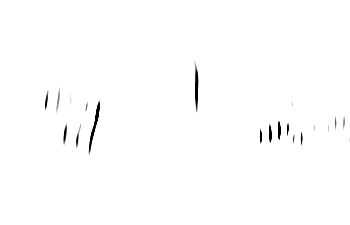

Gabor-filtered image saved to /content/gabor_output_theta_0.png
Gabor Filtered Image (Theta = 1 degrees)


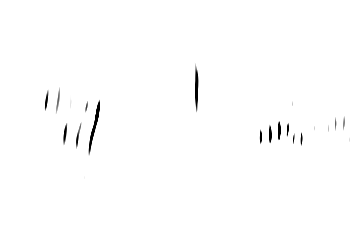

Gabor-filtered image saved to /content/gabor_output_theta_1.png
Gabor Filtered Image (Theta = 2 degrees)


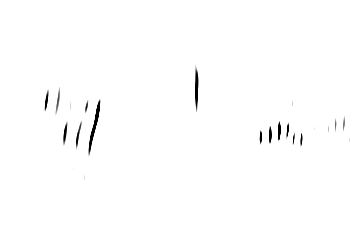

Gabor-filtered image saved to /content/gabor_output_theta_2.png
Gabor Filtered Image (Theta = 3 degrees)


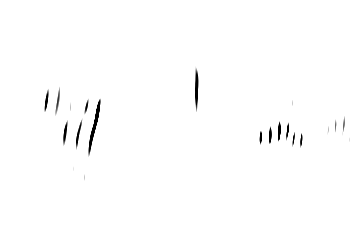

Gabor-filtered image saved to /content/gabor_output_theta_3.png
Gabor Filtered Image (Theta = 4 degrees)


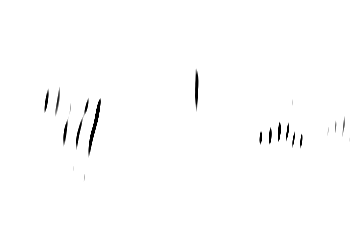

Gabor-filtered image saved to /content/gabor_output_theta_4.png
Gabor Filtered Image (Theta = 5 degrees)


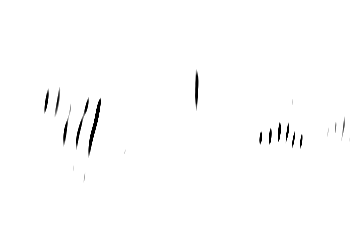

Gabor-filtered image saved to /content/gabor_output_theta_5.png
Gabor Filtered Image (Theta = 6 degrees)


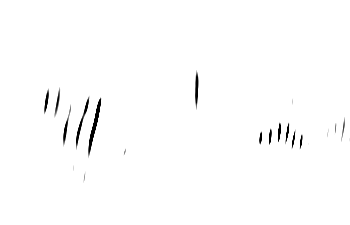

Gabor-filtered image saved to /content/gabor_output_theta_6.png
Gabor Filtered Image (Theta = 7 degrees)


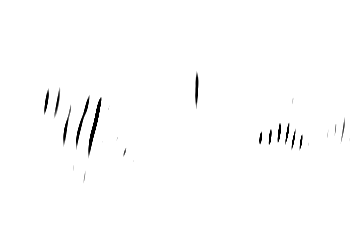

Gabor-filtered image saved to /content/gabor_output_theta_7.png
Gabor Filtered Image (Theta = 8 degrees)


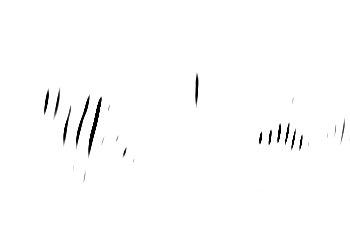

Gabor-filtered image saved to /content/gabor_output_theta_8.png
Gabor Filtered Image (Theta = 9 degrees)


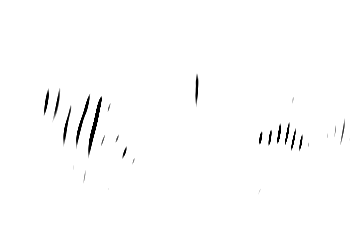

Gabor-filtered image saved to /content/gabor_output_theta_9.png
Gabor Filtered Image (Theta = 10 degrees)


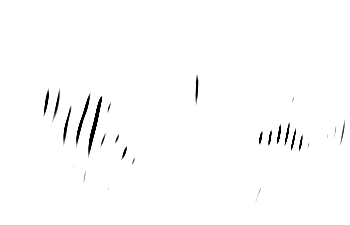

Gabor-filtered image saved to /content/gabor_output_theta_10.png
Gabor Filtered Image (Theta = 11 degrees)


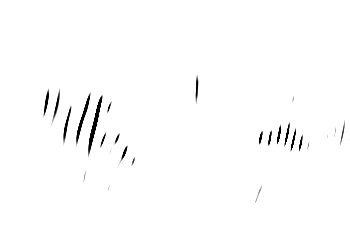

Gabor-filtered image saved to /content/gabor_output_theta_11.png
Gabor Filtered Image (Theta = 12 degrees)


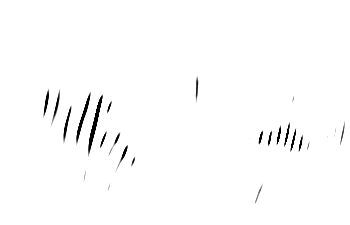

Gabor-filtered image saved to /content/gabor_output_theta_12.png
Gabor Filtered Image (Theta = 13 degrees)


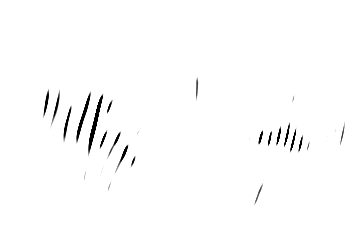

Gabor-filtered image saved to /content/gabor_output_theta_13.png
Gabor Filtered Image (Theta = 14 degrees)


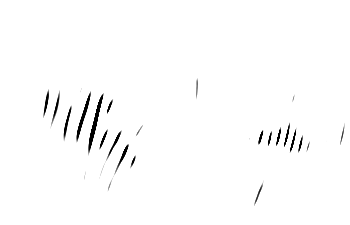

Gabor-filtered image saved to /content/gabor_output_theta_14.png
Gabor Filtered Image (Theta = 15 degrees)


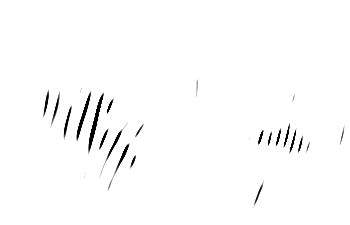

Gabor-filtered image saved to /content/gabor_output_theta_15.png
Gabor Filtered Image (Theta = 16 degrees)


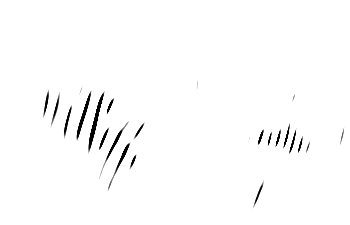

Gabor-filtered image saved to /content/gabor_output_theta_16.png
Gabor Filtered Image (Theta = 17 degrees)


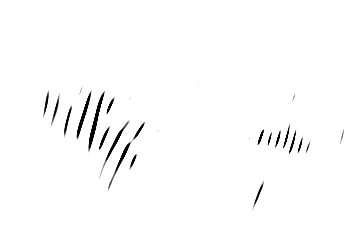

Gabor-filtered image saved to /content/gabor_output_theta_17.png
Gabor Filtered Image (Theta = 18 degrees)


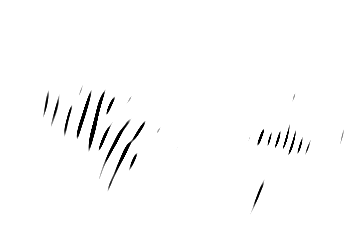

Gabor-filtered image saved to /content/gabor_output_theta_18.png
Gabor Filtered Image (Theta = 19 degrees)


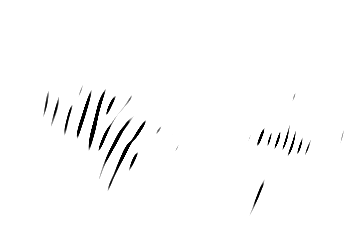

Gabor-filtered image saved to /content/gabor_output_theta_19.png
Gabor Filtered Image (Theta = 20 degrees)


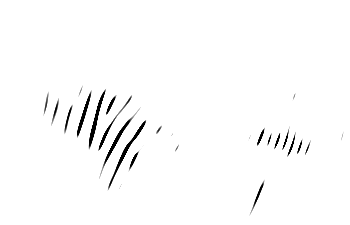

Gabor-filtered image saved to /content/gabor_output_theta_20.png
Gabor Filtered Image (Theta = 21 degrees)


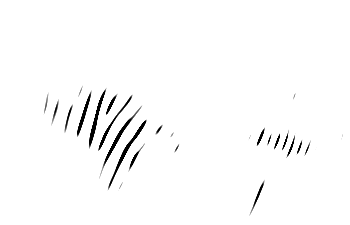

Gabor-filtered image saved to /content/gabor_output_theta_21.png
Gabor Filtered Image (Theta = 22 degrees)


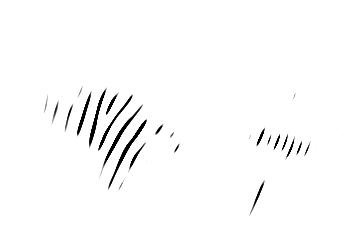

Gabor-filtered image saved to /content/gabor_output_theta_22.png
Gabor Filtered Image (Theta = 23 degrees)


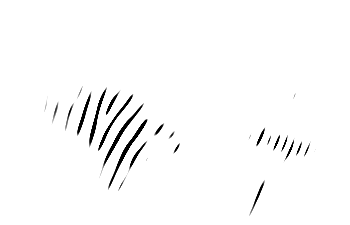

Gabor-filtered image saved to /content/gabor_output_theta_23.png
Gabor Filtered Image (Theta = 24 degrees)


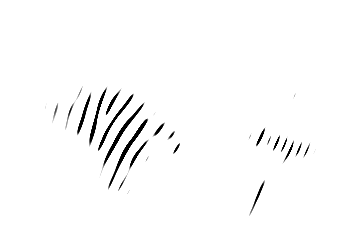

Gabor-filtered image saved to /content/gabor_output_theta_24.png
Gabor Filtered Image (Theta = 25 degrees)


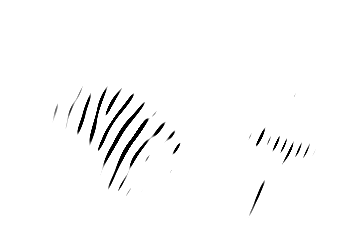

Gabor-filtered image saved to /content/gabor_output_theta_25.png
Gabor Filtered Image (Theta = 26 degrees)


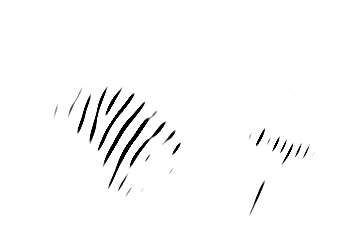

Gabor-filtered image saved to /content/gabor_output_theta_26.png
Gabor Filtered Image (Theta = 27 degrees)


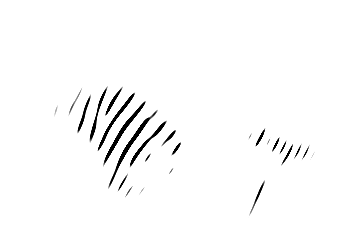

Gabor-filtered image saved to /content/gabor_output_theta_27.png
Gabor Filtered Image (Theta = 28 degrees)


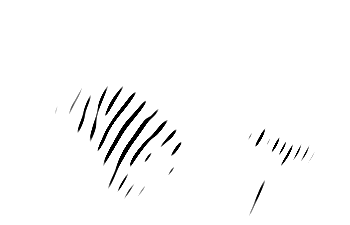

Gabor-filtered image saved to /content/gabor_output_theta_28.png
Gabor Filtered Image (Theta = 29 degrees)


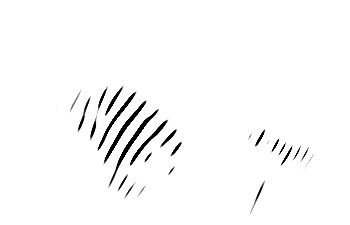

Gabor-filtered image saved to /content/gabor_output_theta_29.png
Gabor Filtered Image (Theta = 30 degrees)


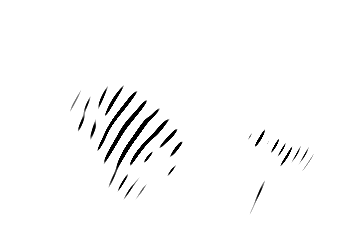

Gabor-filtered image saved to /content/gabor_output_theta_30.png
Gabor Filtered Image (Theta = 31 degrees)


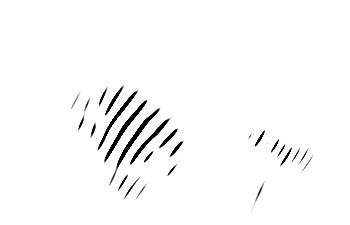

Gabor-filtered image saved to /content/gabor_output_theta_31.png
Gabor Filtered Image (Theta = 32 degrees)


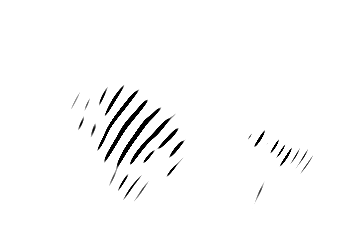

Gabor-filtered image saved to /content/gabor_output_theta_32.png
Gabor Filtered Image (Theta = 33 degrees)


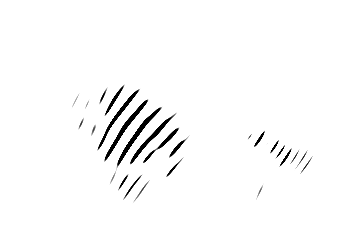

Gabor-filtered image saved to /content/gabor_output_theta_33.png
Gabor Filtered Image (Theta = 34 degrees)


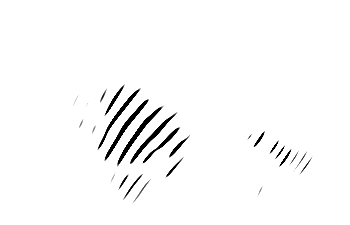

Gabor-filtered image saved to /content/gabor_output_theta_34.png
Gabor Filtered Image (Theta = 35 degrees)


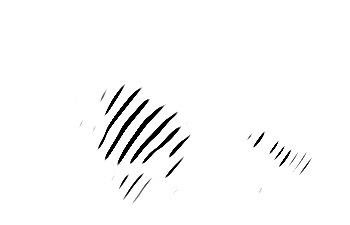

Gabor-filtered image saved to /content/gabor_output_theta_35.png
Gabor Filtered Image (Theta = 36 degrees)


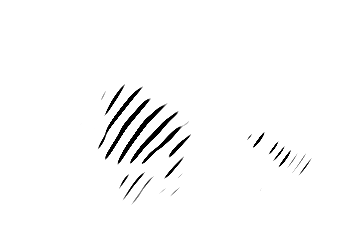

Gabor-filtered image saved to /content/gabor_output_theta_36.png
Gabor Filtered Image (Theta = 37 degrees)


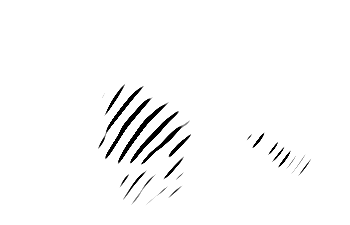

Gabor-filtered image saved to /content/gabor_output_theta_37.png
Gabor Filtered Image (Theta = 38 degrees)


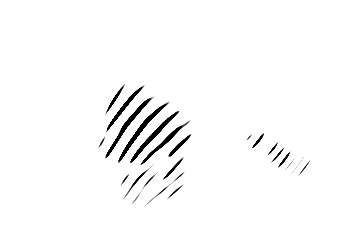

Gabor-filtered image saved to /content/gabor_output_theta_38.png
Gabor Filtered Image (Theta = 39 degrees)


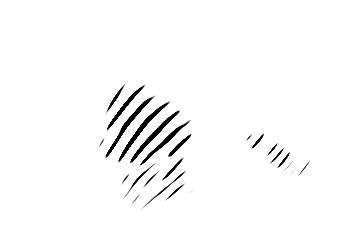

Gabor-filtered image saved to /content/gabor_output_theta_39.png
Gabor Filtered Image (Theta = 40 degrees)


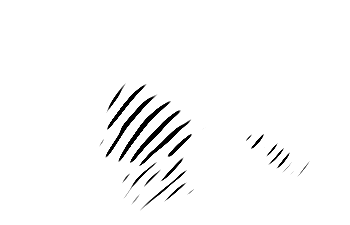

Gabor-filtered image saved to /content/gabor_output_theta_40.png
Gabor Filtered Image (Theta = 41 degrees)


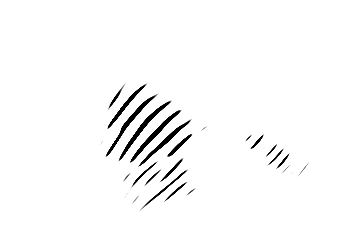

Gabor-filtered image saved to /content/gabor_output_theta_41.png
Gabor Filtered Image (Theta = 42 degrees)


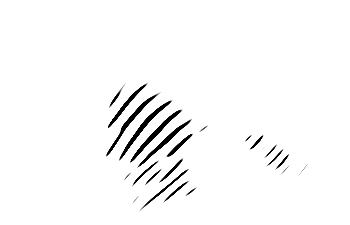

Gabor-filtered image saved to /content/gabor_output_theta_42.png
Gabor Filtered Image (Theta = 43 degrees)


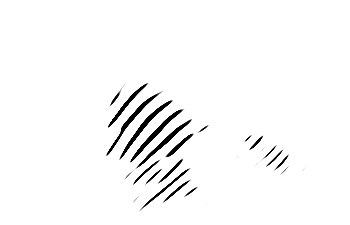

Gabor-filtered image saved to /content/gabor_output_theta_43.png
Gabor Filtered Image (Theta = 44 degrees)


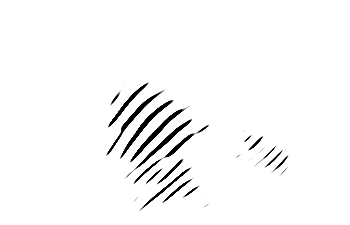

Gabor-filtered image saved to /content/gabor_output_theta_44.png
Gabor Filtered Image (Theta = 45 degrees)


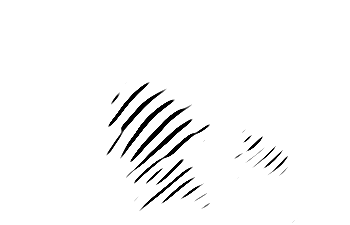

Gabor-filtered image saved to /content/gabor_output_theta_45.png
Gabor Filtered Image (Theta = 46 degrees)


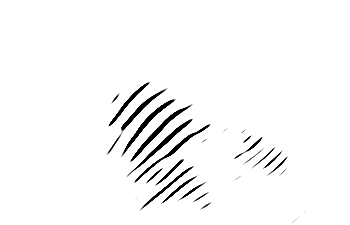

Gabor-filtered image saved to /content/gabor_output_theta_46.png
Gabor Filtered Image (Theta = 47 degrees)


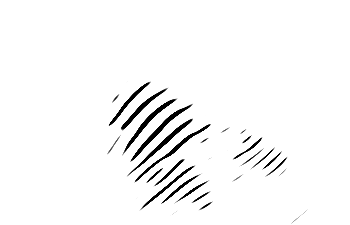

Gabor-filtered image saved to /content/gabor_output_theta_47.png
Gabor Filtered Image (Theta = 48 degrees)


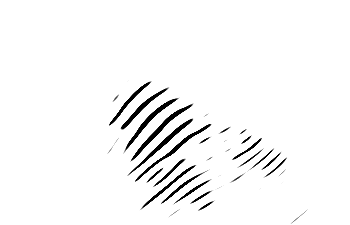

Gabor-filtered image saved to /content/gabor_output_theta_48.png
Gabor Filtered Image (Theta = 49 degrees)


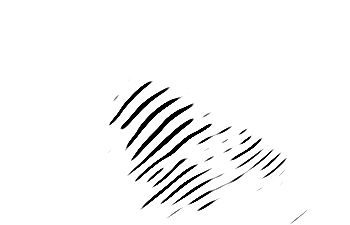

Gabor-filtered image saved to /content/gabor_output_theta_49.png
Gabor Filtered Image (Theta = 50 degrees)


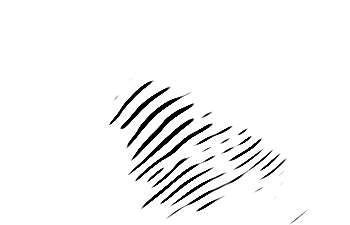

Gabor-filtered image saved to /content/gabor_output_theta_50.png
Gabor Filtered Image (Theta = 51 degrees)


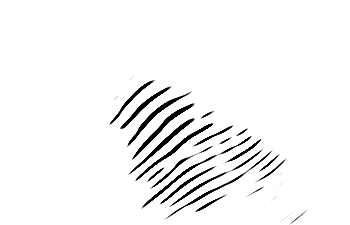

Gabor-filtered image saved to /content/gabor_output_theta_51.png
Gabor Filtered Image (Theta = 52 degrees)


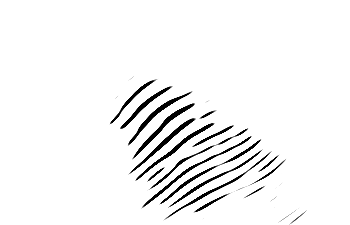

Gabor-filtered image saved to /content/gabor_output_theta_52.png
Gabor Filtered Image (Theta = 53 degrees)


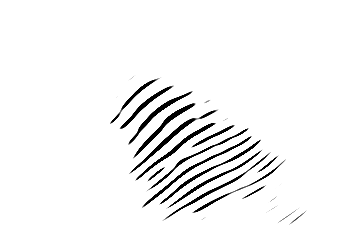

Gabor-filtered image saved to /content/gabor_output_theta_53.png
Gabor Filtered Image (Theta = 54 degrees)


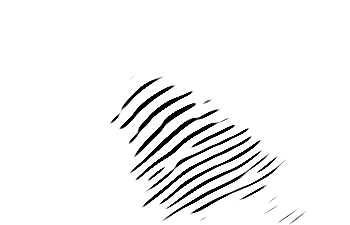

Gabor-filtered image saved to /content/gabor_output_theta_54.png
Gabor Filtered Image (Theta = 55 degrees)


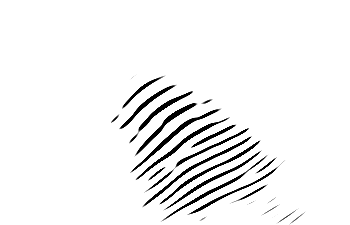

Gabor-filtered image saved to /content/gabor_output_theta_55.png
Gabor Filtered Image (Theta = 56 degrees)


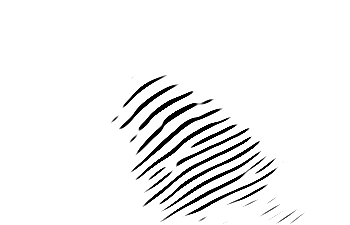

Gabor-filtered image saved to /content/gabor_output_theta_56.png
Gabor Filtered Image (Theta = 57 degrees)


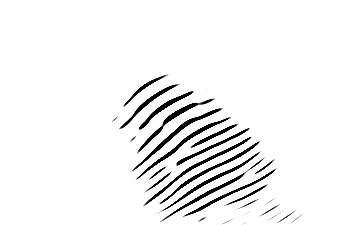

Gabor-filtered image saved to /content/gabor_output_theta_57.png
Gabor Filtered Image (Theta = 58 degrees)


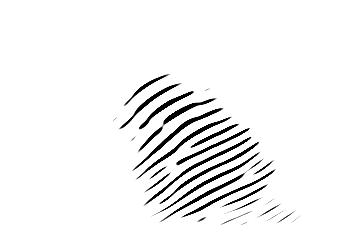

Gabor-filtered image saved to /content/gabor_output_theta_58.png
Gabor Filtered Image (Theta = 59 degrees)


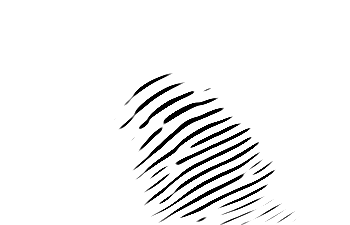

Gabor-filtered image saved to /content/gabor_output_theta_59.png
Gabor Filtered Image (Theta = 60 degrees)


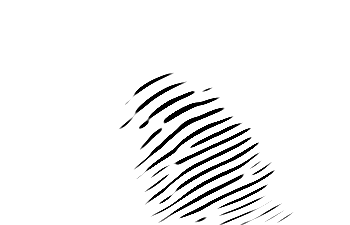

Gabor-filtered image saved to /content/gabor_output_theta_60.png
Gabor Filtered Image (Theta = 61 degrees)


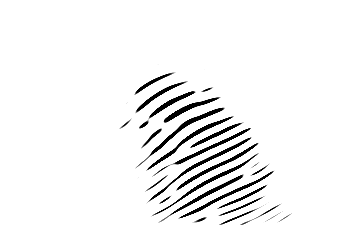

Gabor-filtered image saved to /content/gabor_output_theta_61.png
Gabor Filtered Image (Theta = 62 degrees)


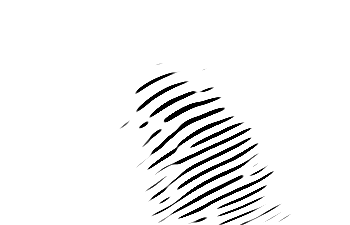

Gabor-filtered image saved to /content/gabor_output_theta_62.png
Gabor Filtered Image (Theta = 63 degrees)


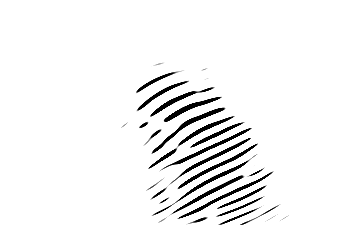

Gabor-filtered image saved to /content/gabor_output_theta_63.png
Gabor Filtered Image (Theta = 64 degrees)


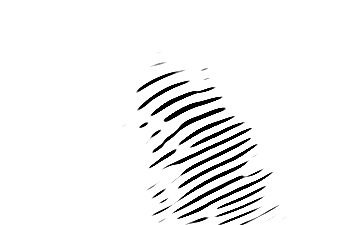

Gabor-filtered image saved to /content/gabor_output_theta_64.png
Gabor Filtered Image (Theta = 65 degrees)


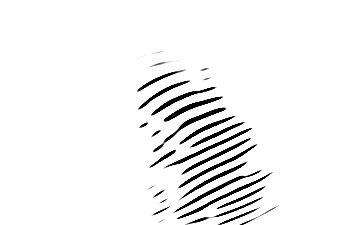

Gabor-filtered image saved to /content/gabor_output_theta_65.png
Gabor Filtered Image (Theta = 66 degrees)


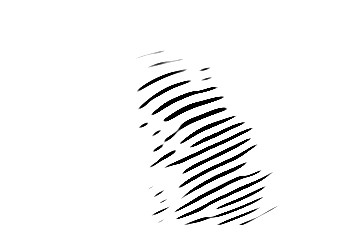

Gabor-filtered image saved to /content/gabor_output_theta_66.png
Gabor Filtered Image (Theta = 67 degrees)


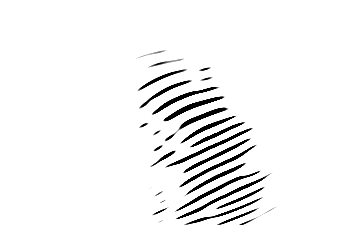

Gabor-filtered image saved to /content/gabor_output_theta_67.png
Gabor Filtered Image (Theta = 68 degrees)


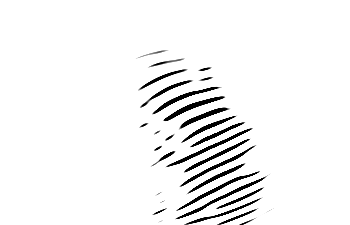

Gabor-filtered image saved to /content/gabor_output_theta_68.png
Gabor Filtered Image (Theta = 69 degrees)


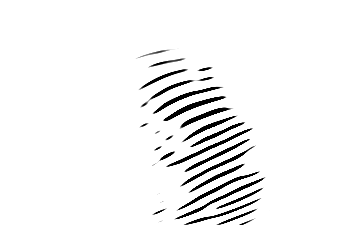

Gabor-filtered image saved to /content/gabor_output_theta_69.png
Gabor Filtered Image (Theta = 70 degrees)


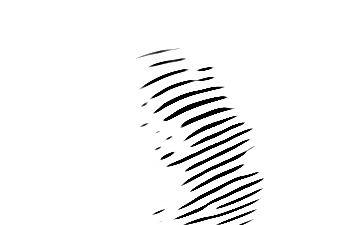

Gabor-filtered image saved to /content/gabor_output_theta_70.png
Gabor Filtered Image (Theta = 71 degrees)


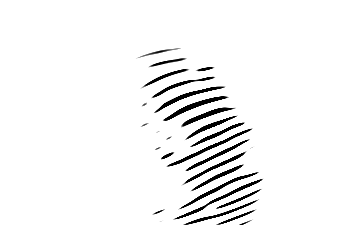

Gabor-filtered image saved to /content/gabor_output_theta_71.png
Gabor Filtered Image (Theta = 72 degrees)


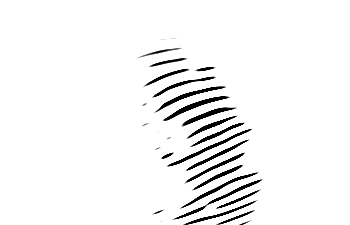

Gabor-filtered image saved to /content/gabor_output_theta_72.png
Gabor Filtered Image (Theta = 73 degrees)


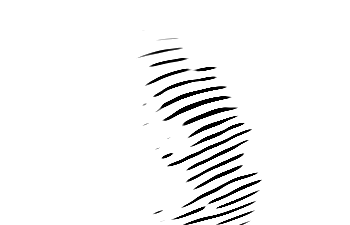

Gabor-filtered image saved to /content/gabor_output_theta_73.png
Gabor Filtered Image (Theta = 74 degrees)


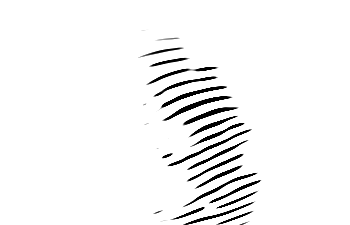

Gabor-filtered image saved to /content/gabor_output_theta_74.png
Gabor Filtered Image (Theta = 75 degrees)


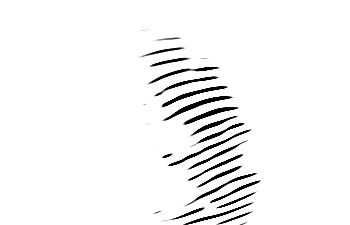

Gabor-filtered image saved to /content/gabor_output_theta_75.png
Gabor Filtered Image (Theta = 76 degrees)


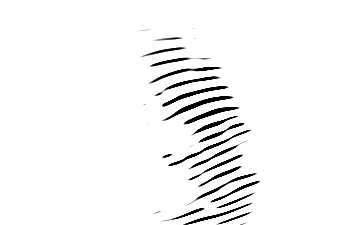

Gabor-filtered image saved to /content/gabor_output_theta_76.png
Gabor Filtered Image (Theta = 77 degrees)


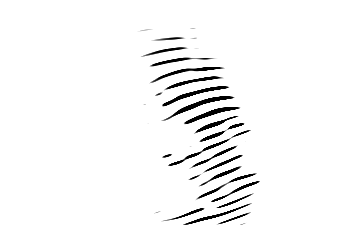

Gabor-filtered image saved to /content/gabor_output_theta_77.png
Gabor Filtered Image (Theta = 78 degrees)


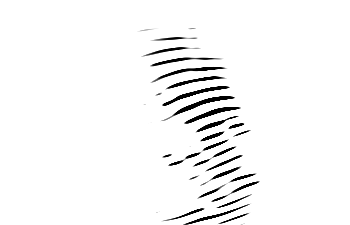

Gabor-filtered image saved to /content/gabor_output_theta_78.png
Gabor Filtered Image (Theta = 79 degrees)


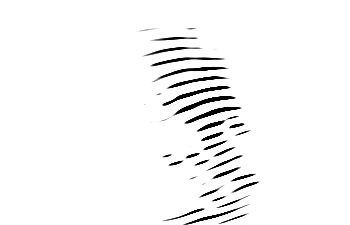

Gabor-filtered image saved to /content/gabor_output_theta_79.png
Gabor Filtered Image (Theta = 80 degrees)


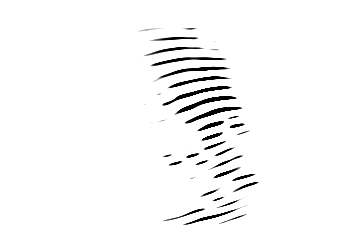

Gabor-filtered image saved to /content/gabor_output_theta_80.png
Gabor Filtered Image (Theta = 81 degrees)


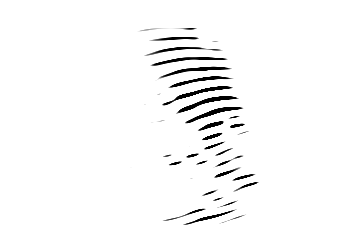

Gabor-filtered image saved to /content/gabor_output_theta_81.png
Gabor Filtered Image (Theta = 82 degrees)


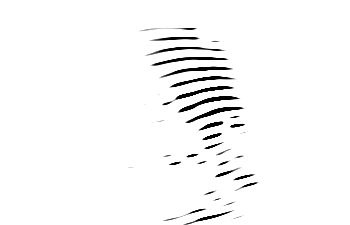

Gabor-filtered image saved to /content/gabor_output_theta_82.png
Gabor Filtered Image (Theta = 83 degrees)


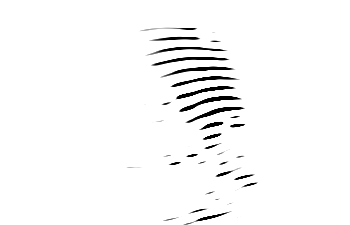

Gabor-filtered image saved to /content/gabor_output_theta_83.png
Gabor Filtered Image (Theta = 84 degrees)


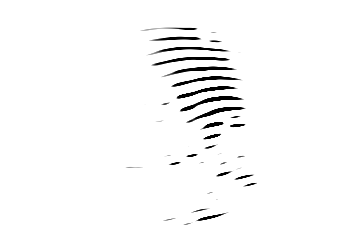

Gabor-filtered image saved to /content/gabor_output_theta_84.png
Gabor Filtered Image (Theta = 85 degrees)


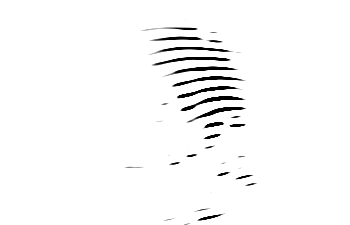

Gabor-filtered image saved to /content/gabor_output_theta_85.png
Gabor Filtered Image (Theta = 86 degrees)


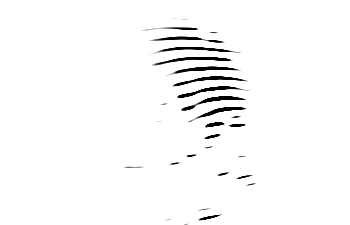

Gabor-filtered image saved to /content/gabor_output_theta_86.png
Gabor Filtered Image (Theta = 87 degrees)


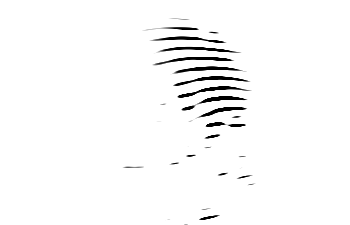

Gabor-filtered image saved to /content/gabor_output_theta_87.png
Gabor Filtered Image (Theta = 88 degrees)


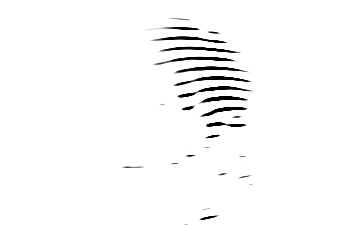

Gabor-filtered image saved to /content/gabor_output_theta_88.png
Gabor Filtered Image (Theta = 89 degrees)


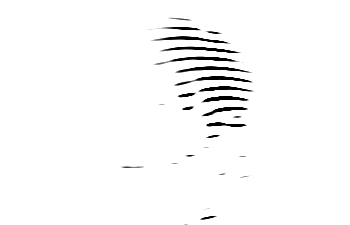

Gabor-filtered image saved to /content/gabor_output_theta_89.png
Gabor Filtered Image (Theta = 90 degrees)


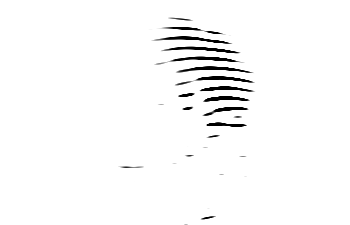

Gabor-filtered image saved to /content/gabor_output_theta_90.png
Gabor Filtered Image (Theta = 91 degrees)


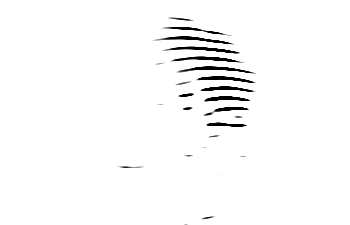

Gabor-filtered image saved to /content/gabor_output_theta_91.png
Gabor Filtered Image (Theta = 92 degrees)


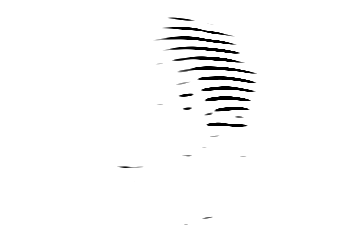

Gabor-filtered image saved to /content/gabor_output_theta_92.png
Gabor Filtered Image (Theta = 93 degrees)


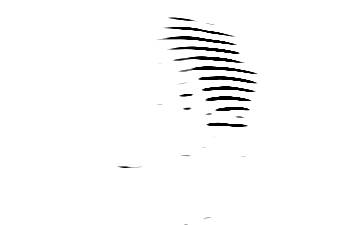

Gabor-filtered image saved to /content/gabor_output_theta_93.png
Gabor Filtered Image (Theta = 94 degrees)


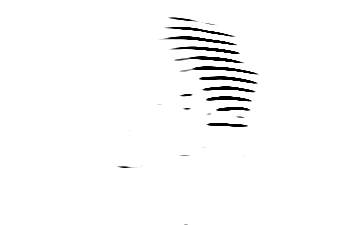

Gabor-filtered image saved to /content/gabor_output_theta_94.png
Gabor Filtered Image (Theta = 95 degrees)


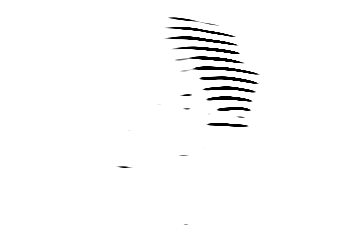

Gabor-filtered image saved to /content/gabor_output_theta_95.png
Gabor Filtered Image (Theta = 96 degrees)


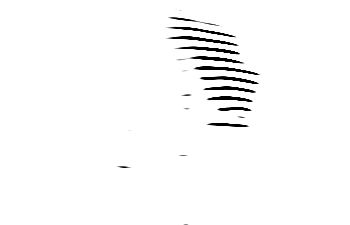

Gabor-filtered image saved to /content/gabor_output_theta_96.png
Gabor Filtered Image (Theta = 97 degrees)


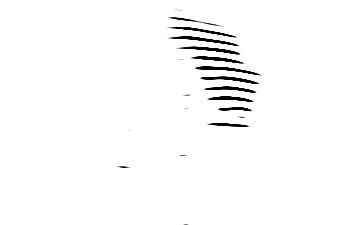

Gabor-filtered image saved to /content/gabor_output_theta_97.png
Gabor Filtered Image (Theta = 98 degrees)


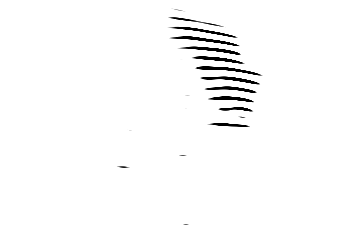

Gabor-filtered image saved to /content/gabor_output_theta_98.png
Gabor Filtered Image (Theta = 99 degrees)


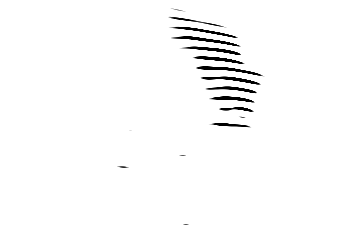

Gabor-filtered image saved to /content/gabor_output_theta_99.png
Gabor Filtered Image (Theta = 100 degrees)


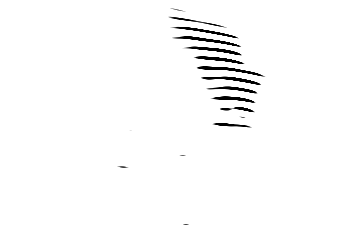

Gabor-filtered image saved to /content/gabor_output_theta_100.png
Gabor Filtered Image (Theta = 101 degrees)


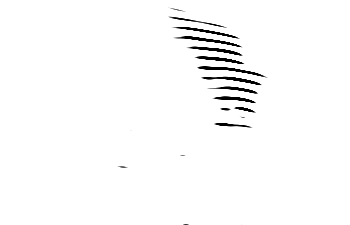

Gabor-filtered image saved to /content/gabor_output_theta_101.png
Gabor Filtered Image (Theta = 102 degrees)


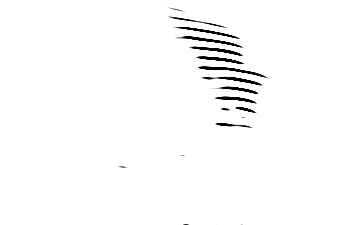

Gabor-filtered image saved to /content/gabor_output_theta_102.png
Gabor Filtered Image (Theta = 103 degrees)


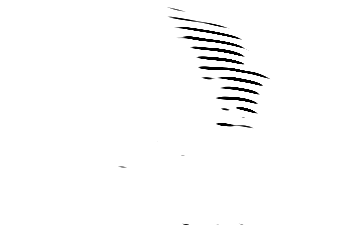

Gabor-filtered image saved to /content/gabor_output_theta_103.png
Gabor Filtered Image (Theta = 104 degrees)


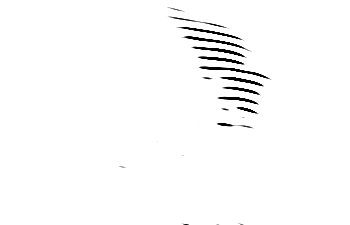

Gabor-filtered image saved to /content/gabor_output_theta_104.png
Gabor Filtered Image (Theta = 105 degrees)


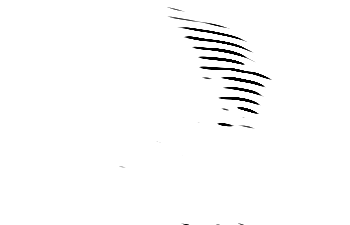

Gabor-filtered image saved to /content/gabor_output_theta_105.png
Gabor Filtered Image (Theta = 106 degrees)


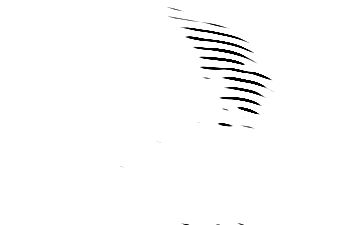

Gabor-filtered image saved to /content/gabor_output_theta_106.png
Gabor Filtered Image (Theta = 107 degrees)


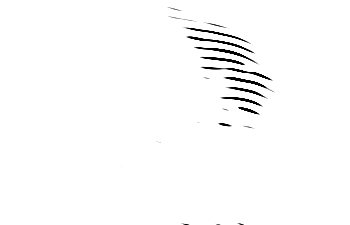

Gabor-filtered image saved to /content/gabor_output_theta_107.png
Gabor Filtered Image (Theta = 108 degrees)


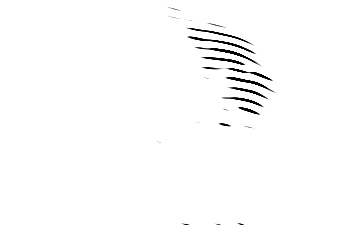

Gabor-filtered image saved to /content/gabor_output_theta_108.png
Gabor Filtered Image (Theta = 109 degrees)


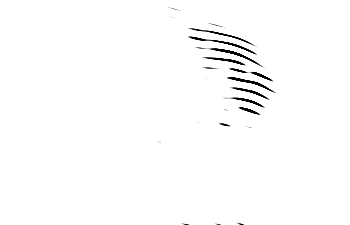

Gabor-filtered image saved to /content/gabor_output_theta_109.png
Gabor Filtered Image (Theta = 110 degrees)


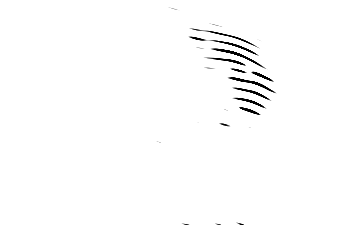

Gabor-filtered image saved to /content/gabor_output_theta_110.png
Gabor Filtered Image (Theta = 111 degrees)


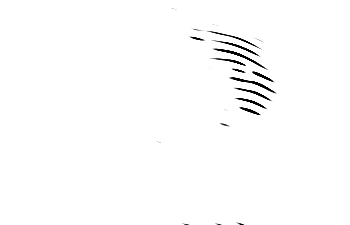

Gabor-filtered image saved to /content/gabor_output_theta_111.png
Gabor Filtered Image (Theta = 112 degrees)


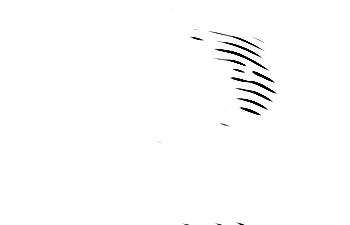

Gabor-filtered image saved to /content/gabor_output_theta_112.png
Gabor Filtered Image (Theta = 113 degrees)


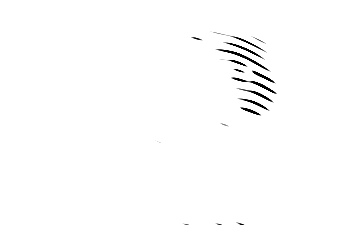

Gabor-filtered image saved to /content/gabor_output_theta_113.png
Gabor Filtered Image (Theta = 114 degrees)


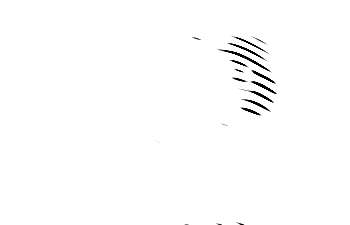

Gabor-filtered image saved to /content/gabor_output_theta_114.png
Gabor Filtered Image (Theta = 115 degrees)


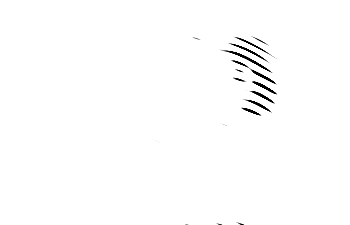

Gabor-filtered image saved to /content/gabor_output_theta_115.png
Gabor Filtered Image (Theta = 116 degrees)


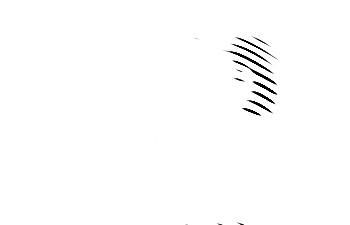

Gabor-filtered image saved to /content/gabor_output_theta_116.png
Gabor Filtered Image (Theta = 117 degrees)


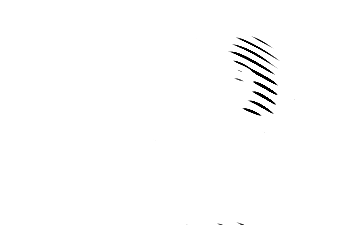

Gabor-filtered image saved to /content/gabor_output_theta_117.png
Gabor Filtered Image (Theta = 118 degrees)


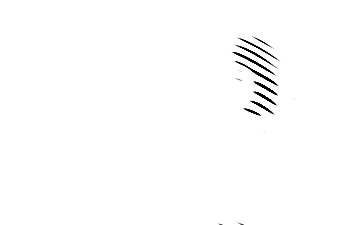

Gabor-filtered image saved to /content/gabor_output_theta_118.png
Gabor Filtered Image (Theta = 119 degrees)


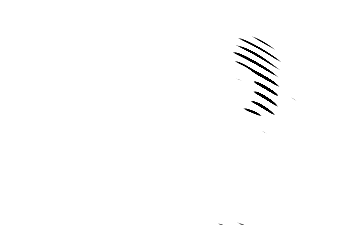

Gabor-filtered image saved to /content/gabor_output_theta_119.png
Gabor Filtered Image (Theta = 120 degrees)


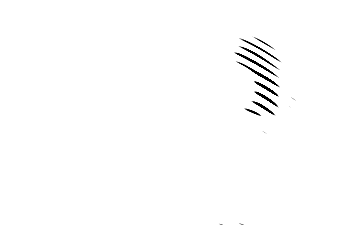

Gabor-filtered image saved to /content/gabor_output_theta_120.png
Gabor Filtered Image (Theta = 121 degrees)


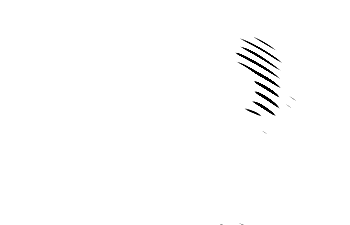

Gabor-filtered image saved to /content/gabor_output_theta_121.png
Gabor Filtered Image (Theta = 122 degrees)


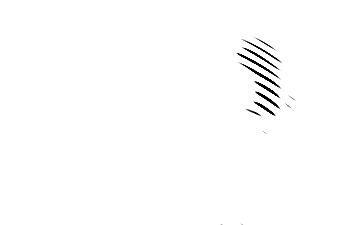

Gabor-filtered image saved to /content/gabor_output_theta_122.png
Gabor Filtered Image (Theta = 123 degrees)


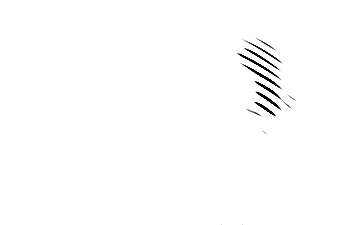

Gabor-filtered image saved to /content/gabor_output_theta_123.png
Gabor Filtered Image (Theta = 124 degrees)


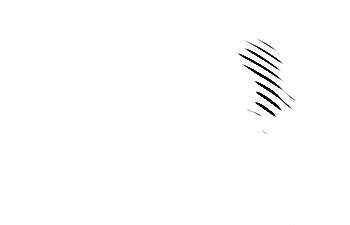

Gabor-filtered image saved to /content/gabor_output_theta_124.png
Gabor Filtered Image (Theta = 125 degrees)


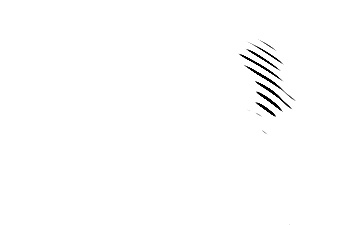

Gabor-filtered image saved to /content/gabor_output_theta_125.png
Gabor Filtered Image (Theta = 126 degrees)


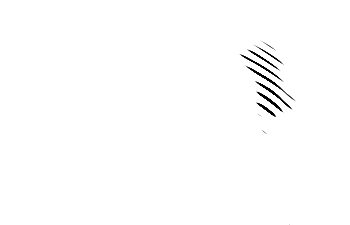

Gabor-filtered image saved to /content/gabor_output_theta_126.png
Gabor Filtered Image (Theta = 127 degrees)


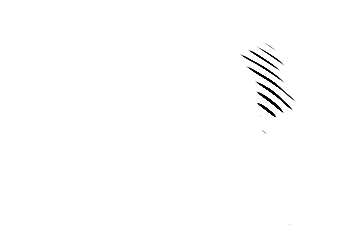

Gabor-filtered image saved to /content/gabor_output_theta_127.png
Gabor Filtered Image (Theta = 128 degrees)


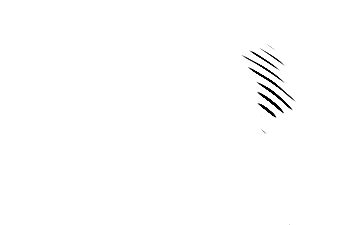

Gabor-filtered image saved to /content/gabor_output_theta_128.png
Gabor Filtered Image (Theta = 129 degrees)


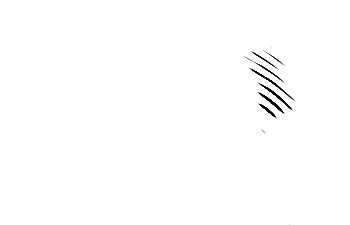

Gabor-filtered image saved to /content/gabor_output_theta_129.png
Gabor Filtered Image (Theta = 130 degrees)


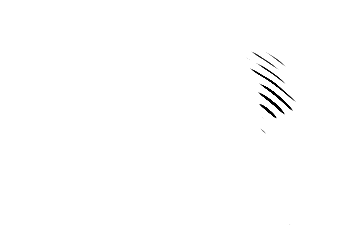

Gabor-filtered image saved to /content/gabor_output_theta_130.png
Gabor Filtered Image (Theta = 131 degrees)


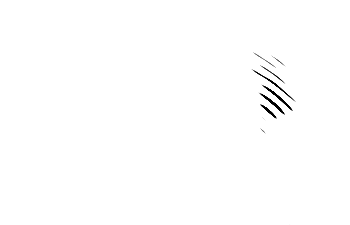

Gabor-filtered image saved to /content/gabor_output_theta_131.png
Gabor Filtered Image (Theta = 132 degrees)


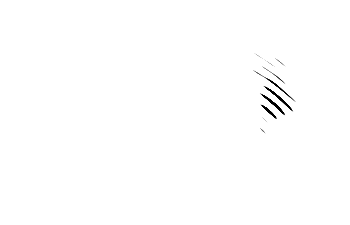

Gabor-filtered image saved to /content/gabor_output_theta_132.png
Gabor Filtered Image (Theta = 133 degrees)


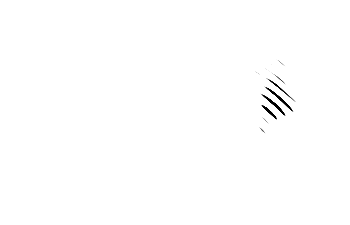

Gabor-filtered image saved to /content/gabor_output_theta_133.png
Gabor Filtered Image (Theta = 134 degrees)


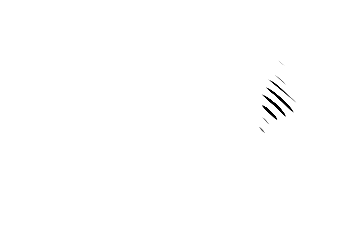

Gabor-filtered image saved to /content/gabor_output_theta_134.png
Gabor Filtered Image (Theta = 135 degrees)


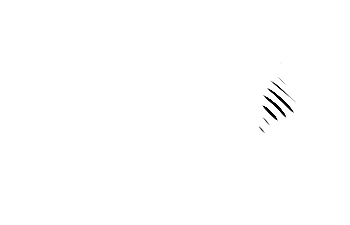

Gabor-filtered image saved to /content/gabor_output_theta_135.png
Gabor Filtered Image (Theta = 136 degrees)


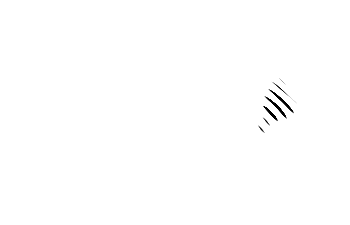

Gabor-filtered image saved to /content/gabor_output_theta_136.png
Gabor Filtered Image (Theta = 137 degrees)


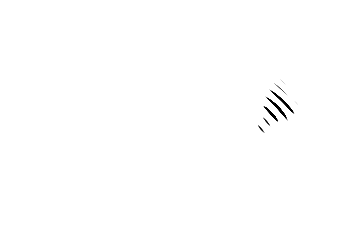

Gabor-filtered image saved to /content/gabor_output_theta_137.png
Gabor Filtered Image (Theta = 138 degrees)


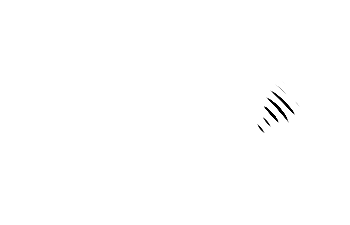

Gabor-filtered image saved to /content/gabor_output_theta_138.png
Gabor Filtered Image (Theta = 139 degrees)


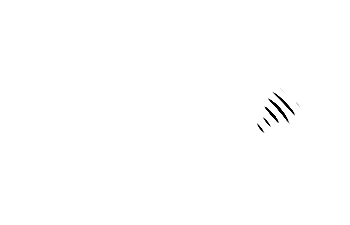

Gabor-filtered image saved to /content/gabor_output_theta_139.png
Gabor Filtered Image (Theta = 140 degrees)


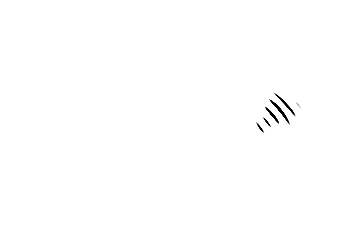

Gabor-filtered image saved to /content/gabor_output_theta_140.png
Gabor Filtered Image (Theta = 141 degrees)


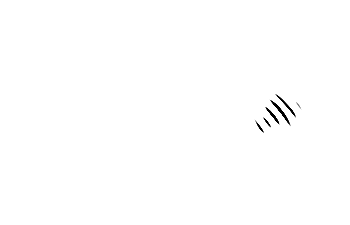

Gabor-filtered image saved to /content/gabor_output_theta_141.png
Gabor Filtered Image (Theta = 142 degrees)


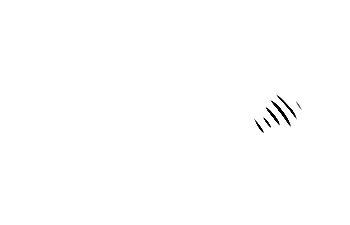

Gabor-filtered image saved to /content/gabor_output_theta_142.png
Gabor Filtered Image (Theta = 143 degrees)


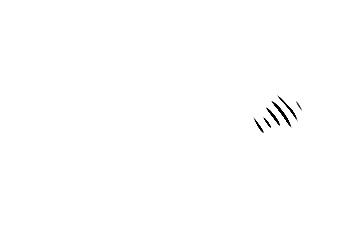

Gabor-filtered image saved to /content/gabor_output_theta_143.png
Gabor Filtered Image (Theta = 144 degrees)


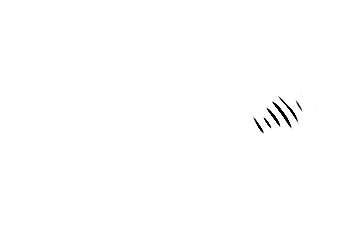

Gabor-filtered image saved to /content/gabor_output_theta_144.png
Gabor Filtered Image (Theta = 145 degrees)


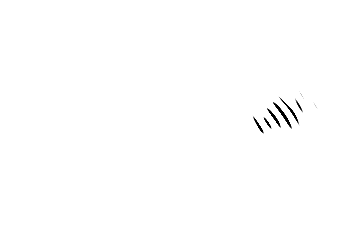

Gabor-filtered image saved to /content/gabor_output_theta_145.png
Gabor Filtered Image (Theta = 146 degrees)


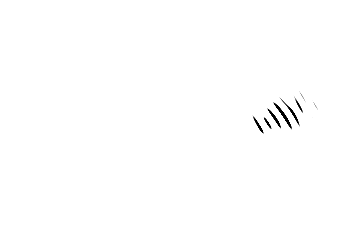

Gabor-filtered image saved to /content/gabor_output_theta_146.png
Gabor Filtered Image (Theta = 147 degrees)


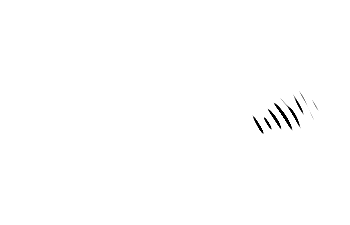

Gabor-filtered image saved to /content/gabor_output_theta_147.png
Gabor Filtered Image (Theta = 148 degrees)


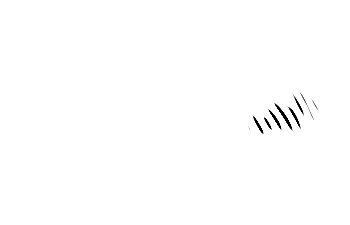

Gabor-filtered image saved to /content/gabor_output_theta_148.png
Gabor Filtered Image (Theta = 149 degrees)


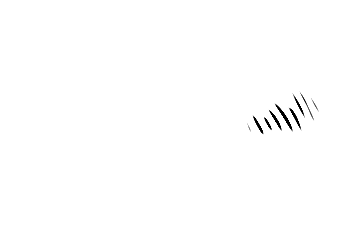

Gabor-filtered image saved to /content/gabor_output_theta_149.png
Gabor Filtered Image (Theta = 150 degrees)


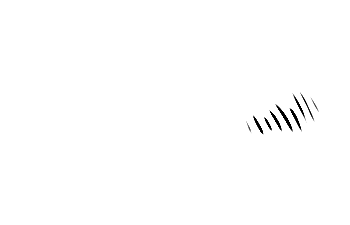

Gabor-filtered image saved to /content/gabor_output_theta_150.png
Gabor Filtered Image (Theta = 151 degrees)


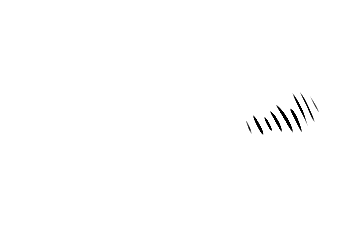

Gabor-filtered image saved to /content/gabor_output_theta_151.png
Gabor Filtered Image (Theta = 152 degrees)


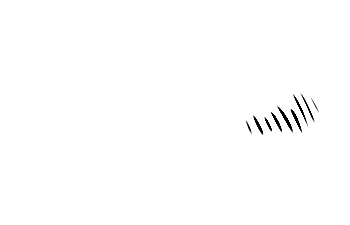

Gabor-filtered image saved to /content/gabor_output_theta_152.png
Gabor Filtered Image (Theta = 153 degrees)


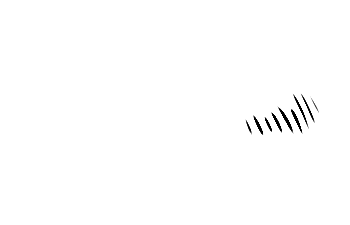

Gabor-filtered image saved to /content/gabor_output_theta_153.png
Gabor Filtered Image (Theta = 154 degrees)


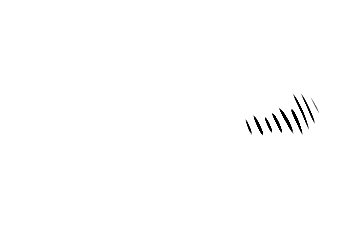

Gabor-filtered image saved to /content/gabor_output_theta_154.png
Gabor Filtered Image (Theta = 155 degrees)


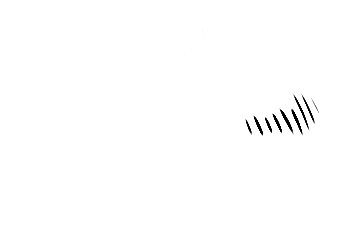

Gabor-filtered image saved to /content/gabor_output_theta_155.png
Gabor Filtered Image (Theta = 156 degrees)


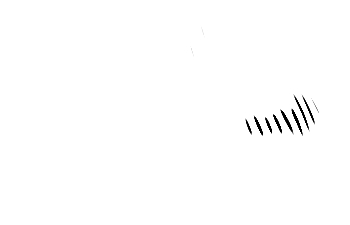

Gabor-filtered image saved to /content/gabor_output_theta_156.png
Gabor Filtered Image (Theta = 157 degrees)


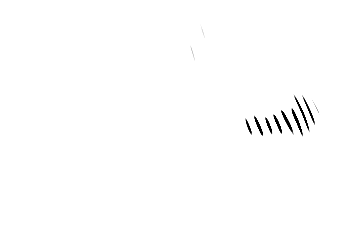

Gabor-filtered image saved to /content/gabor_output_theta_157.png
Gabor Filtered Image (Theta = 158 degrees)


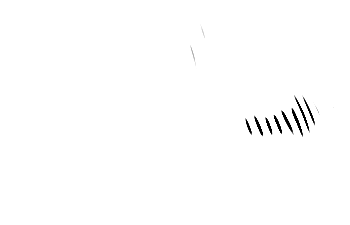

Gabor-filtered image saved to /content/gabor_output_theta_158.png
Gabor Filtered Image (Theta = 159 degrees)


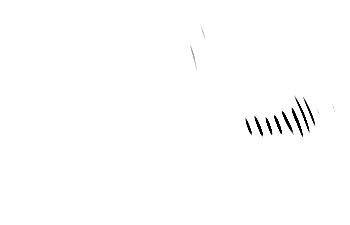

Gabor-filtered image saved to /content/gabor_output_theta_159.png
Gabor Filtered Image (Theta = 160 degrees)


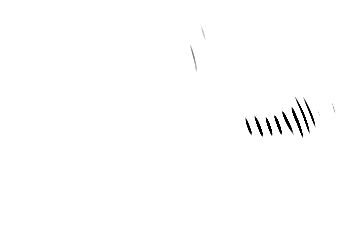

Gabor-filtered image saved to /content/gabor_output_theta_160.png
Gabor Filtered Image (Theta = 161 degrees)


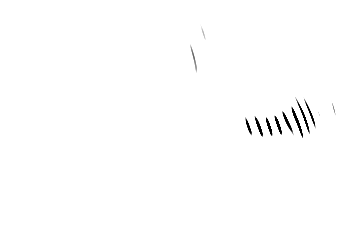

Gabor-filtered image saved to /content/gabor_output_theta_161.png
Gabor Filtered Image (Theta = 162 degrees)


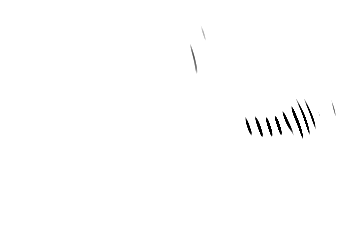

Gabor-filtered image saved to /content/gabor_output_theta_162.png
Gabor Filtered Image (Theta = 163 degrees)


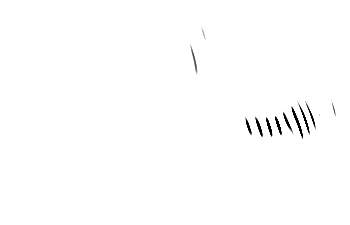

Gabor-filtered image saved to /content/gabor_output_theta_163.png
Gabor Filtered Image (Theta = 164 degrees)


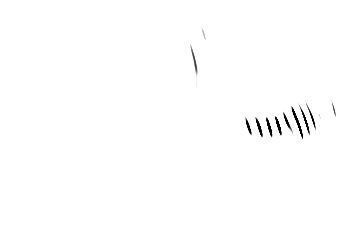

Gabor-filtered image saved to /content/gabor_output_theta_164.png
Gabor Filtered Image (Theta = 165 degrees)


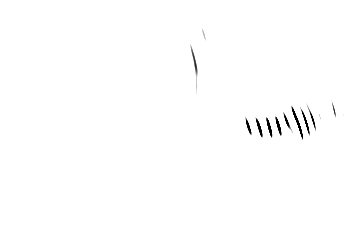

Gabor-filtered image saved to /content/gabor_output_theta_165.png
Gabor Filtered Image (Theta = 166 degrees)


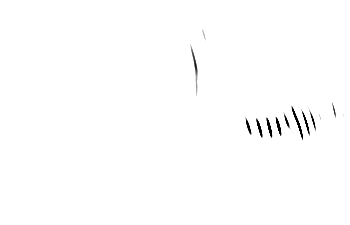

Gabor-filtered image saved to /content/gabor_output_theta_166.png
Gabor Filtered Image (Theta = 167 degrees)


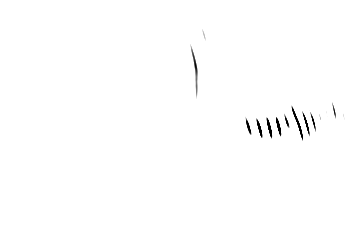

Gabor-filtered image saved to /content/gabor_output_theta_167.png
Gabor Filtered Image (Theta = 168 degrees)


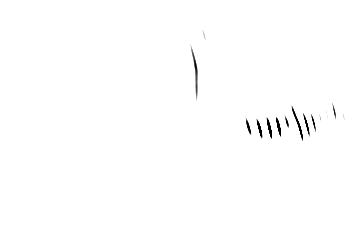

Gabor-filtered image saved to /content/gabor_output_theta_168.png
Gabor Filtered Image (Theta = 169 degrees)


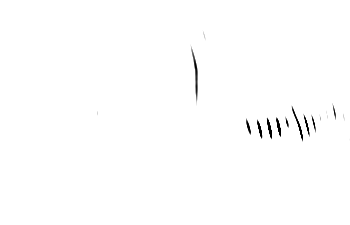

Gabor-filtered image saved to /content/gabor_output_theta_169.png
Gabor Filtered Image (Theta = 170 degrees)


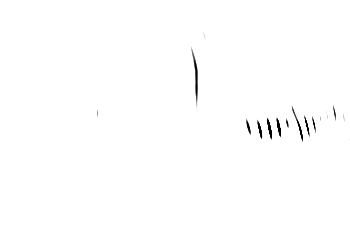

Gabor-filtered image saved to /content/gabor_output_theta_170.png
Gabor Filtered Image (Theta = 171 degrees)


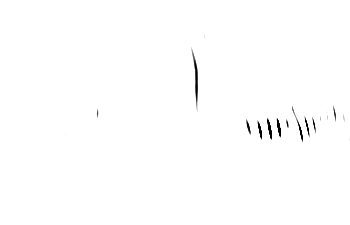

Gabor-filtered image saved to /content/gabor_output_theta_171.png
Gabor Filtered Image (Theta = 172 degrees)


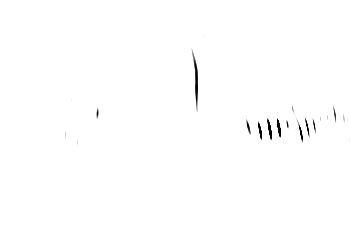

Gabor-filtered image saved to /content/gabor_output_theta_172.png
Gabor Filtered Image (Theta = 173 degrees)


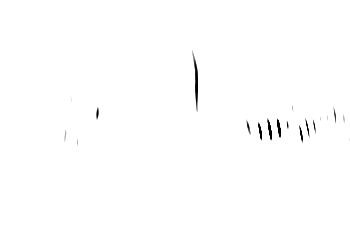

Gabor-filtered image saved to /content/gabor_output_theta_173.png
Gabor Filtered Image (Theta = 174 degrees)


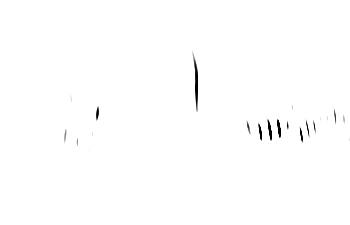

Gabor-filtered image saved to /content/gabor_output_theta_174.png
Gabor Filtered Image (Theta = 175 degrees)


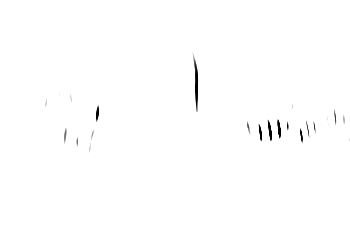

Gabor-filtered image saved to /content/gabor_output_theta_175.png
Gabor Filtered Image (Theta = 176 degrees)


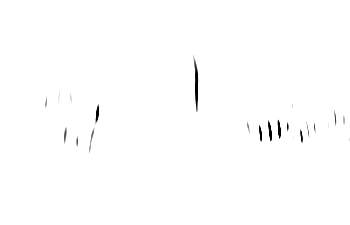

Gabor-filtered image saved to /content/gabor_output_theta_176.png
Gabor Filtered Image (Theta = 177 degrees)


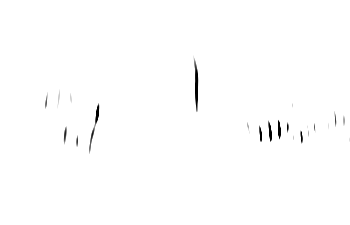

Gabor-filtered image saved to /content/gabor_output_theta_177.png
Gabor Filtered Image (Theta = 178 degrees)


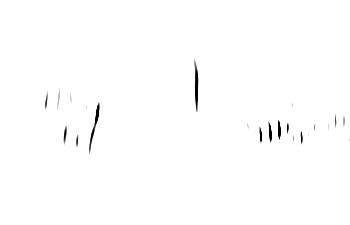

Gabor-filtered image saved to /content/gabor_output_theta_178.png
Gabor Filtered Image (Theta = 179 degrees)


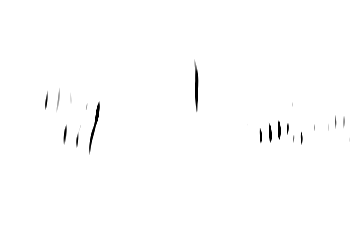

Gabor-filtered image saved to /content/gabor_output_theta_179.png
Gabor Filtered Image (Theta = 180 degrees)


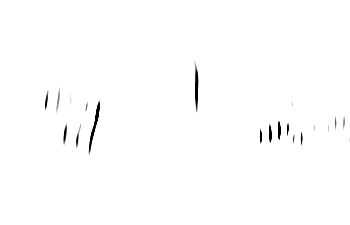

Gabor-filtered image saved to /content/gabor_output_theta_180.png
Gabor Filtered Image (Theta = 181 degrees)


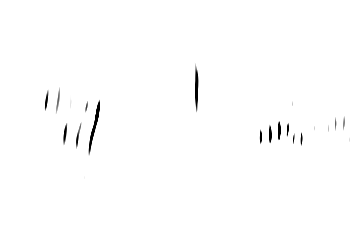

Gabor-filtered image saved to /content/gabor_output_theta_181.png
Gabor Filtered Image (Theta = 182 degrees)


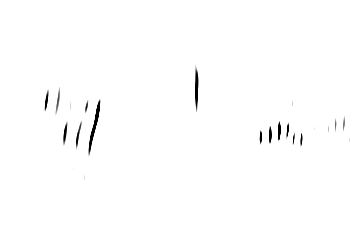

Gabor-filtered image saved to /content/gabor_output_theta_182.png
Gabor Filtered Image (Theta = 183 degrees)


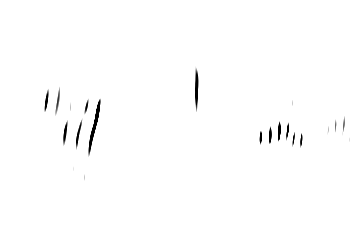

Gabor-filtered image saved to /content/gabor_output_theta_183.png
Gabor Filtered Image (Theta = 184 degrees)


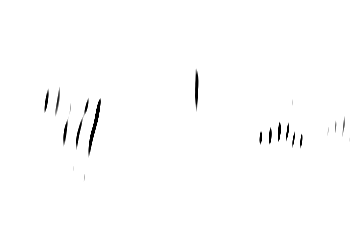

Gabor-filtered image saved to /content/gabor_output_theta_184.png
Gabor Filtered Image (Theta = 185 degrees)


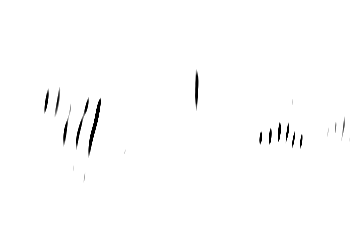

Gabor-filtered image saved to /content/gabor_output_theta_185.png
Gabor Filtered Image (Theta = 186 degrees)


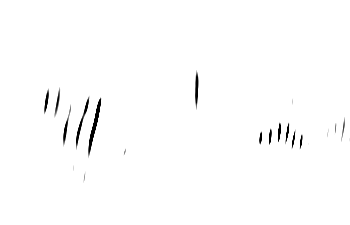

Gabor-filtered image saved to /content/gabor_output_theta_186.png
Gabor Filtered Image (Theta = 187 degrees)


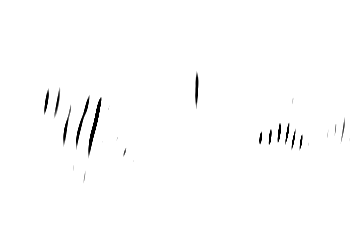

Gabor-filtered image saved to /content/gabor_output_theta_187.png
Gabor Filtered Image (Theta = 188 degrees)


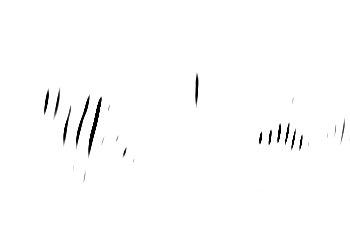

Gabor-filtered image saved to /content/gabor_output_theta_188.png
Gabor Filtered Image (Theta = 189 degrees)


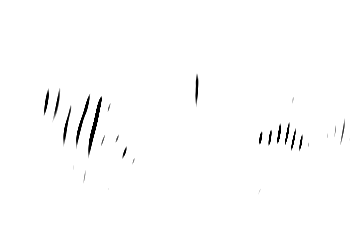

Gabor-filtered image saved to /content/gabor_output_theta_189.png
Gabor Filtered Image (Theta = 190 degrees)


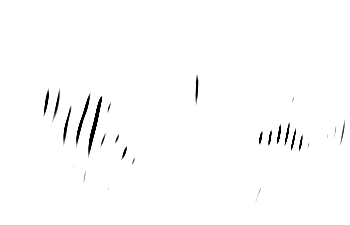

Gabor-filtered image saved to /content/gabor_output_theta_190.png
Gabor Filtered Image (Theta = 191 degrees)


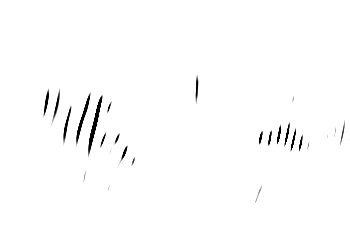

Gabor-filtered image saved to /content/gabor_output_theta_191.png
Gabor Filtered Image (Theta = 192 degrees)


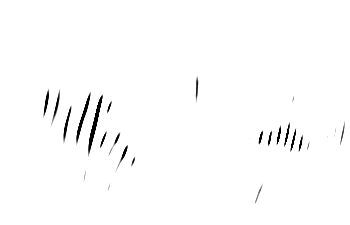

Gabor-filtered image saved to /content/gabor_output_theta_192.png
Gabor Filtered Image (Theta = 193 degrees)


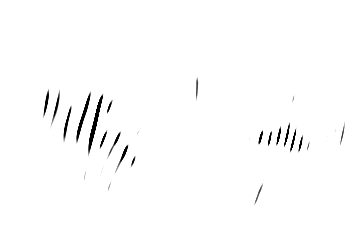

Gabor-filtered image saved to /content/gabor_output_theta_193.png
Gabor Filtered Image (Theta = 194 degrees)


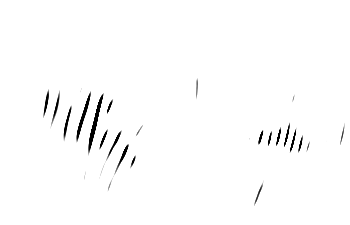

Gabor-filtered image saved to /content/gabor_output_theta_194.png
Gabor Filtered Image (Theta = 195 degrees)


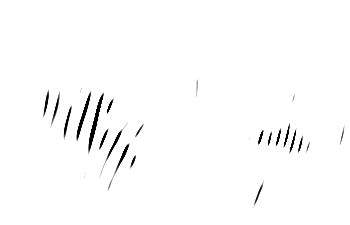

Gabor-filtered image saved to /content/gabor_output_theta_195.png
Gabor Filtered Image (Theta = 196 degrees)


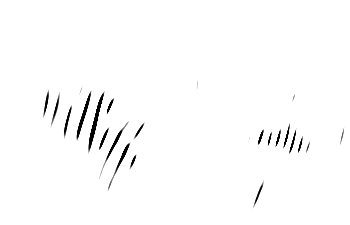

Gabor-filtered image saved to /content/gabor_output_theta_196.png
Gabor Filtered Image (Theta = 197 degrees)


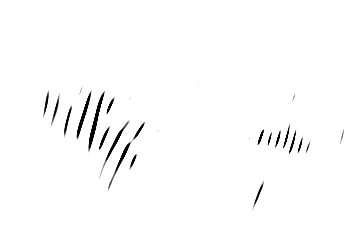

Gabor-filtered image saved to /content/gabor_output_theta_197.png
Gabor Filtered Image (Theta = 198 degrees)


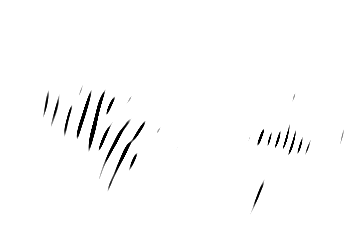

Gabor-filtered image saved to /content/gabor_output_theta_198.png
Gabor Filtered Image (Theta = 199 degrees)


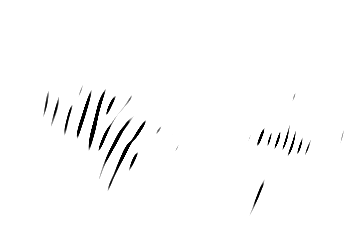

Gabor-filtered image saved to /content/gabor_output_theta_199.png
Gabor Filtered Image (Theta = 200 degrees)


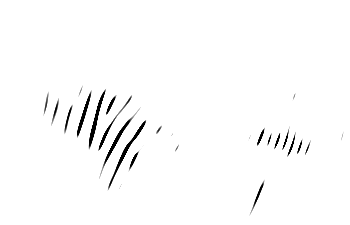

Gabor-filtered image saved to /content/gabor_output_theta_200.png
Gabor Filtered Image (Theta = 201 degrees)


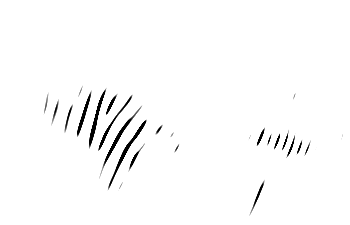

Gabor-filtered image saved to /content/gabor_output_theta_201.png
Gabor Filtered Image (Theta = 202 degrees)


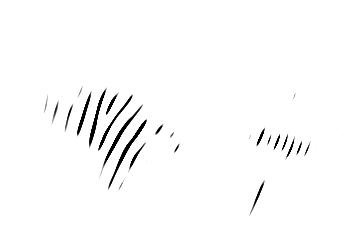

Gabor-filtered image saved to /content/gabor_output_theta_202.png
Gabor Filtered Image (Theta = 203 degrees)


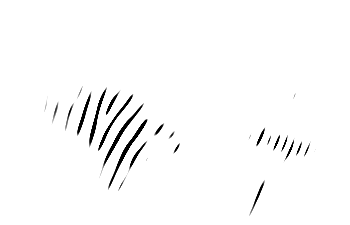

Gabor-filtered image saved to /content/gabor_output_theta_203.png
Gabor Filtered Image (Theta = 204 degrees)


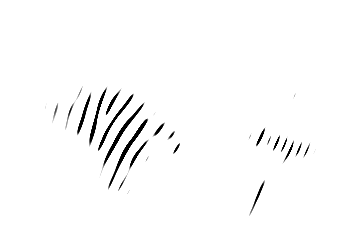

Gabor-filtered image saved to /content/gabor_output_theta_204.png
Gabor Filtered Image (Theta = 205 degrees)


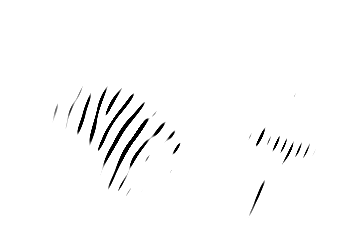

Gabor-filtered image saved to /content/gabor_output_theta_205.png
Gabor Filtered Image (Theta = 206 degrees)


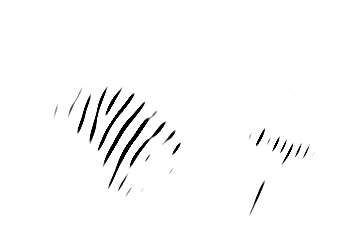

Gabor-filtered image saved to /content/gabor_output_theta_206.png
Gabor Filtered Image (Theta = 207 degrees)


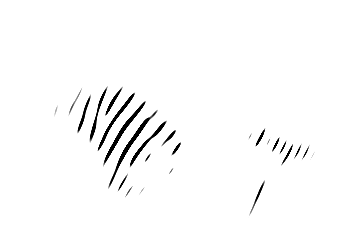

Gabor-filtered image saved to /content/gabor_output_theta_207.png
Gabor Filtered Image (Theta = 208 degrees)


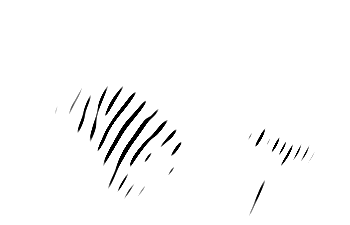

Gabor-filtered image saved to /content/gabor_output_theta_208.png
Gabor Filtered Image (Theta = 209 degrees)


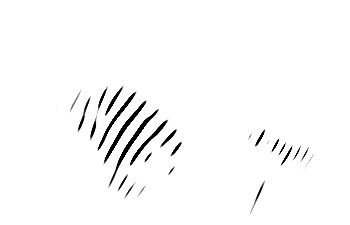

Gabor-filtered image saved to /content/gabor_output_theta_209.png
Gabor Filtered Image (Theta = 210 degrees)


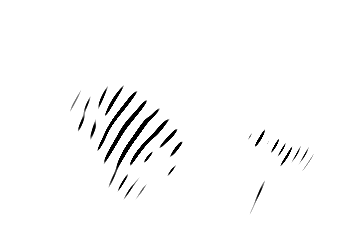

Gabor-filtered image saved to /content/gabor_output_theta_210.png
Gabor Filtered Image (Theta = 211 degrees)


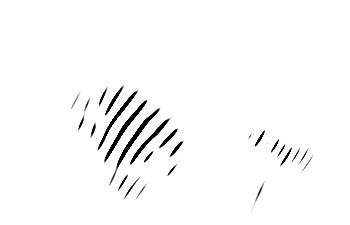

Gabor-filtered image saved to /content/gabor_output_theta_211.png
Gabor Filtered Image (Theta = 212 degrees)


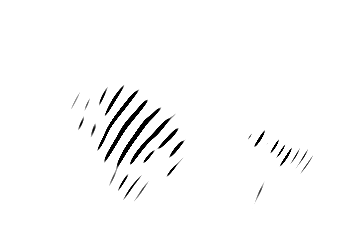

Gabor-filtered image saved to /content/gabor_output_theta_212.png
Gabor Filtered Image (Theta = 213 degrees)


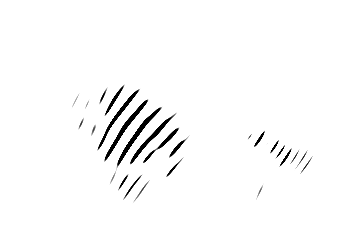

Gabor-filtered image saved to /content/gabor_output_theta_213.png
Gabor Filtered Image (Theta = 214 degrees)


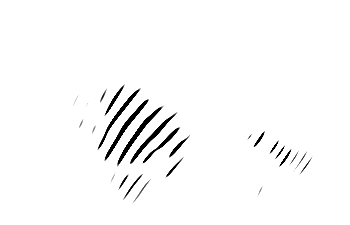

Gabor-filtered image saved to /content/gabor_output_theta_214.png
Gabor Filtered Image (Theta = 215 degrees)


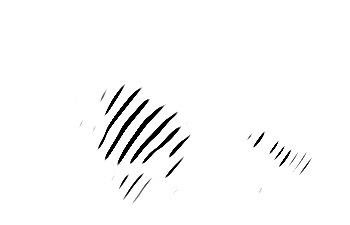

Gabor-filtered image saved to /content/gabor_output_theta_215.png
Gabor Filtered Image (Theta = 216 degrees)


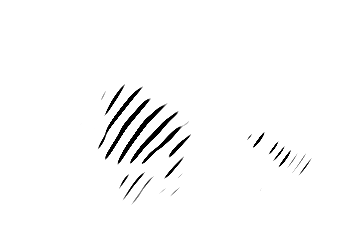

Gabor-filtered image saved to /content/gabor_output_theta_216.png
Gabor Filtered Image (Theta = 217 degrees)


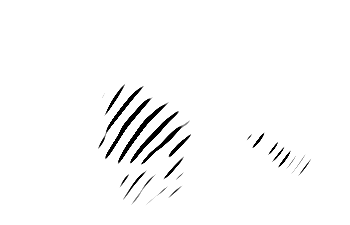

Gabor-filtered image saved to /content/gabor_output_theta_217.png
Gabor Filtered Image (Theta = 218 degrees)


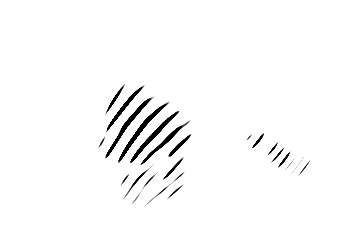

Gabor-filtered image saved to /content/gabor_output_theta_218.png
Gabor Filtered Image (Theta = 219 degrees)


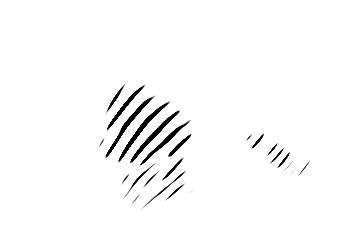

Gabor-filtered image saved to /content/gabor_output_theta_219.png
Gabor Filtered Image (Theta = 220 degrees)


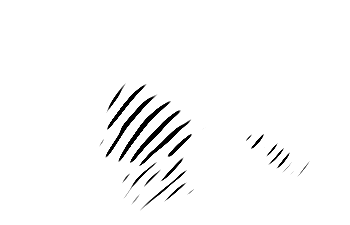

Gabor-filtered image saved to /content/gabor_output_theta_220.png
Gabor Filtered Image (Theta = 221 degrees)


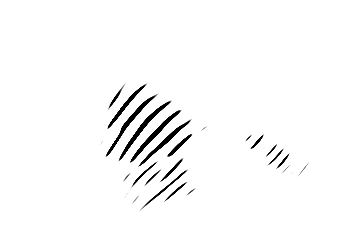

Gabor-filtered image saved to /content/gabor_output_theta_221.png
Gabor Filtered Image (Theta = 222 degrees)


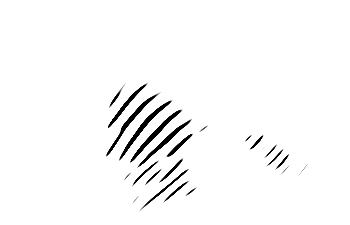

Gabor-filtered image saved to /content/gabor_output_theta_222.png
Gabor Filtered Image (Theta = 223 degrees)


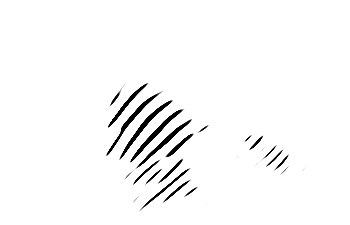

Gabor-filtered image saved to /content/gabor_output_theta_223.png
Gabor Filtered Image (Theta = 224 degrees)


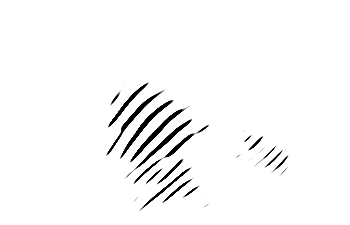

Gabor-filtered image saved to /content/gabor_output_theta_224.png
Gabor Filtered Image (Theta = 225 degrees)


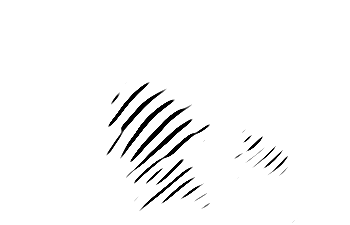

Gabor-filtered image saved to /content/gabor_output_theta_225.png
Gabor Filtered Image (Theta = 226 degrees)


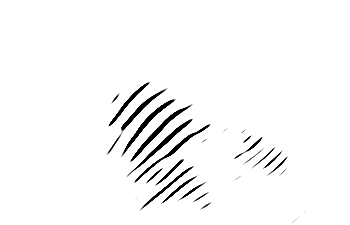

Gabor-filtered image saved to /content/gabor_output_theta_226.png
Gabor Filtered Image (Theta = 227 degrees)


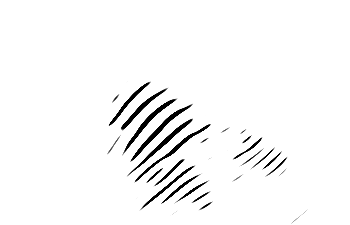

Gabor-filtered image saved to /content/gabor_output_theta_227.png
Gabor Filtered Image (Theta = 228 degrees)


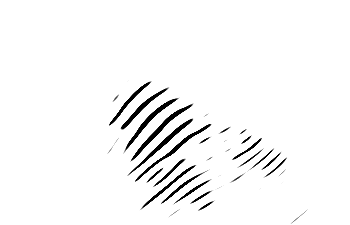

Gabor-filtered image saved to /content/gabor_output_theta_228.png
Gabor Filtered Image (Theta = 229 degrees)


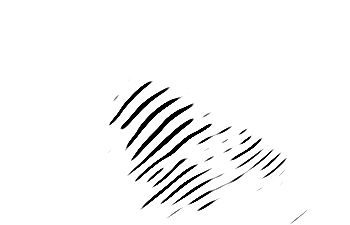

Gabor-filtered image saved to /content/gabor_output_theta_229.png
Gabor Filtered Image (Theta = 230 degrees)


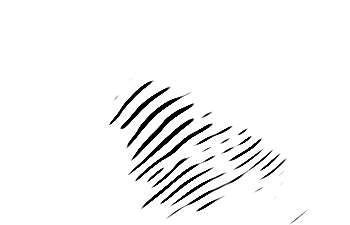

Gabor-filtered image saved to /content/gabor_output_theta_230.png
Gabor Filtered Image (Theta = 231 degrees)


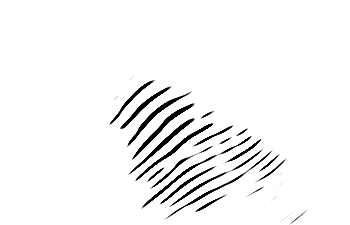

Gabor-filtered image saved to /content/gabor_output_theta_231.png
Gabor Filtered Image (Theta = 232 degrees)


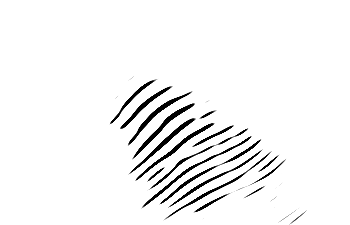

Gabor-filtered image saved to /content/gabor_output_theta_232.png
Gabor Filtered Image (Theta = 233 degrees)


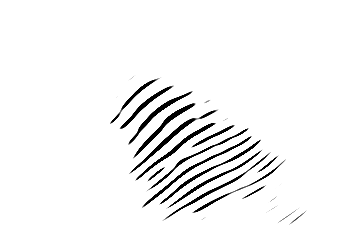

Gabor-filtered image saved to /content/gabor_output_theta_233.png
Gabor Filtered Image (Theta = 234 degrees)


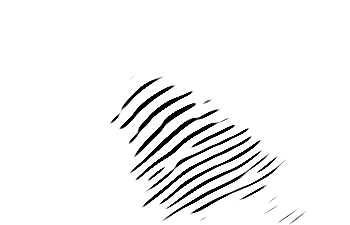

Gabor-filtered image saved to /content/gabor_output_theta_234.png
Gabor Filtered Image (Theta = 235 degrees)


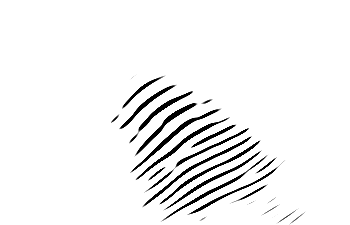

Gabor-filtered image saved to /content/gabor_output_theta_235.png
Gabor Filtered Image (Theta = 236 degrees)


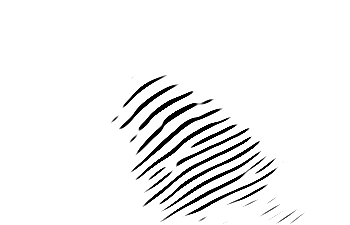

Gabor-filtered image saved to /content/gabor_output_theta_236.png
Gabor Filtered Image (Theta = 237 degrees)


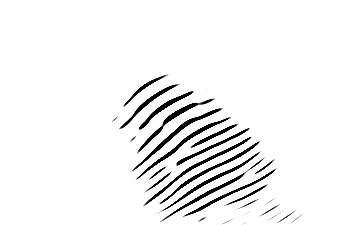

Gabor-filtered image saved to /content/gabor_output_theta_237.png
Gabor Filtered Image (Theta = 238 degrees)


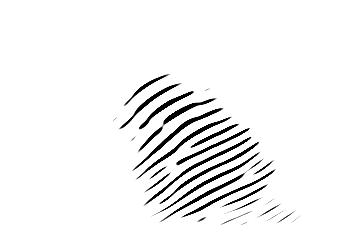

Gabor-filtered image saved to /content/gabor_output_theta_238.png
Gabor Filtered Image (Theta = 239 degrees)


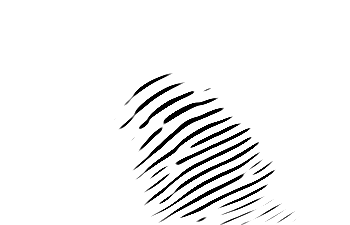

Gabor-filtered image saved to /content/gabor_output_theta_239.png
Gabor Filtered Image (Theta = 240 degrees)


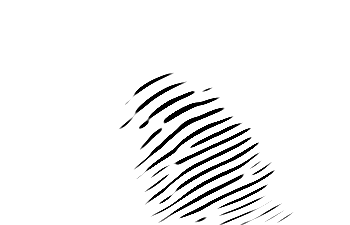

Gabor-filtered image saved to /content/gabor_output_theta_240.png
Gabor Filtered Image (Theta = 241 degrees)


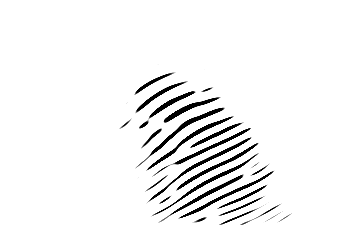

Gabor-filtered image saved to /content/gabor_output_theta_241.png
Gabor Filtered Image (Theta = 242 degrees)


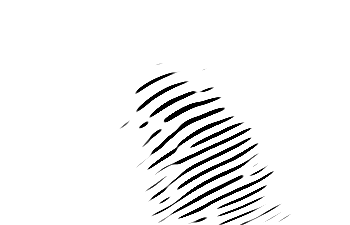

Gabor-filtered image saved to /content/gabor_output_theta_242.png
Gabor Filtered Image (Theta = 243 degrees)


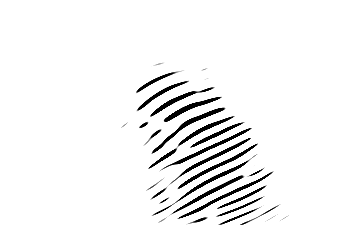

Gabor-filtered image saved to /content/gabor_output_theta_243.png
Gabor Filtered Image (Theta = 244 degrees)


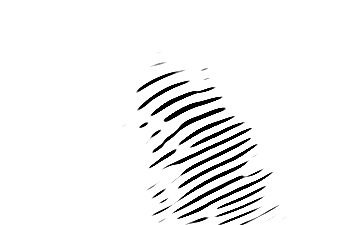

Gabor-filtered image saved to /content/gabor_output_theta_244.png
Gabor Filtered Image (Theta = 245 degrees)


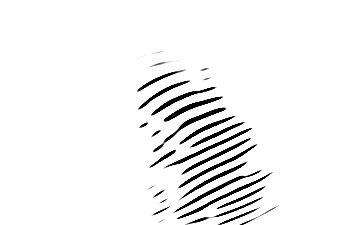

Gabor-filtered image saved to /content/gabor_output_theta_245.png
Gabor Filtered Image (Theta = 246 degrees)


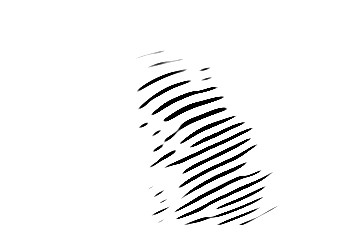

Gabor-filtered image saved to /content/gabor_output_theta_246.png
Gabor Filtered Image (Theta = 247 degrees)


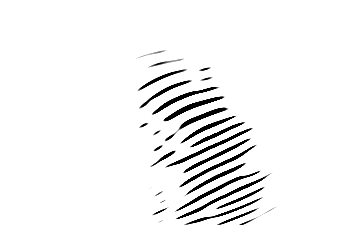

Gabor-filtered image saved to /content/gabor_output_theta_247.png
Gabor Filtered Image (Theta = 248 degrees)


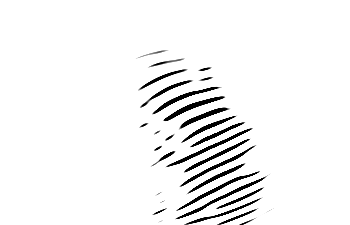

Gabor-filtered image saved to /content/gabor_output_theta_248.png
Gabor Filtered Image (Theta = 249 degrees)


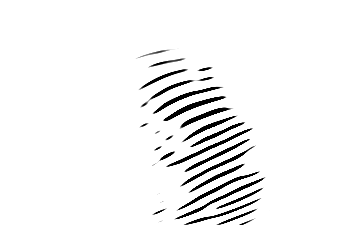

Gabor-filtered image saved to /content/gabor_output_theta_249.png
Gabor Filtered Image (Theta = 250 degrees)


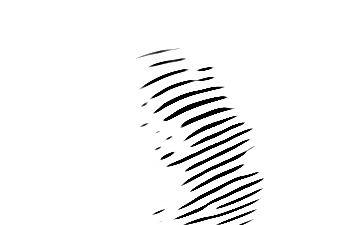

Gabor-filtered image saved to /content/gabor_output_theta_250.png
Gabor Filtered Image (Theta = 251 degrees)


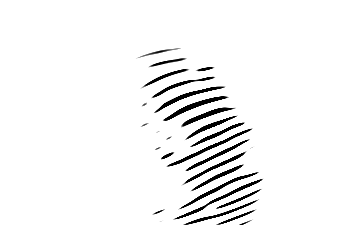

Gabor-filtered image saved to /content/gabor_output_theta_251.png
Gabor Filtered Image (Theta = 252 degrees)


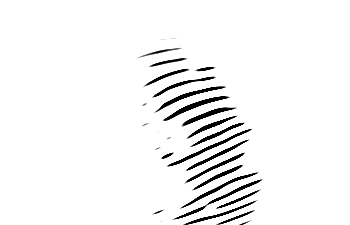

Gabor-filtered image saved to /content/gabor_output_theta_252.png
Gabor Filtered Image (Theta = 253 degrees)


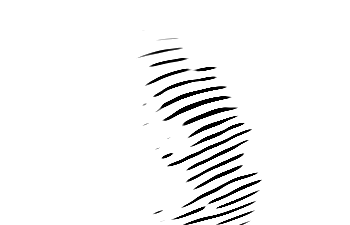

Gabor-filtered image saved to /content/gabor_output_theta_253.png
Gabor Filtered Image (Theta = 254 degrees)


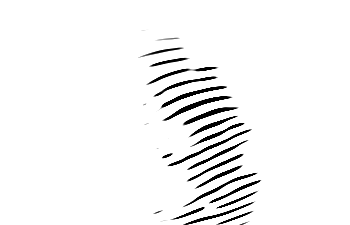

Gabor-filtered image saved to /content/gabor_output_theta_254.png
Gabor Filtered Image (Theta = 255 degrees)


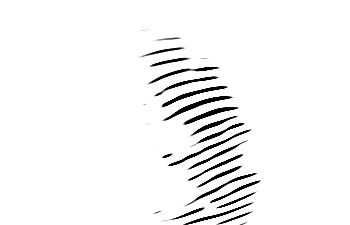

Gabor-filtered image saved to /content/gabor_output_theta_255.png
Gabor Filtered Image (Theta = 256 degrees)


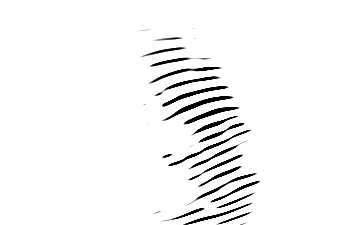

Gabor-filtered image saved to /content/gabor_output_theta_256.png
Gabor Filtered Image (Theta = 257 degrees)


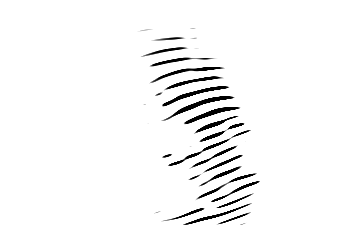

Gabor-filtered image saved to /content/gabor_output_theta_257.png
Gabor Filtered Image (Theta = 258 degrees)


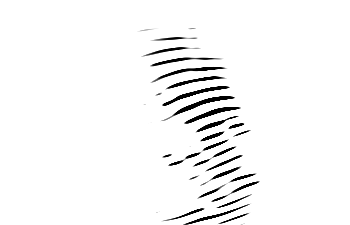

Gabor-filtered image saved to /content/gabor_output_theta_258.png
Gabor Filtered Image (Theta = 259 degrees)


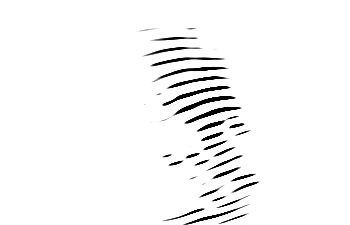

Gabor-filtered image saved to /content/gabor_output_theta_259.png
Gabor Filtered Image (Theta = 260 degrees)


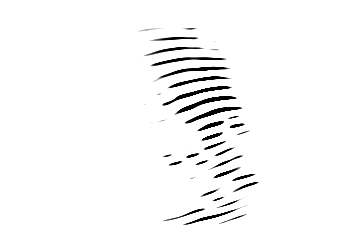

Gabor-filtered image saved to /content/gabor_output_theta_260.png
Gabor Filtered Image (Theta = 261 degrees)


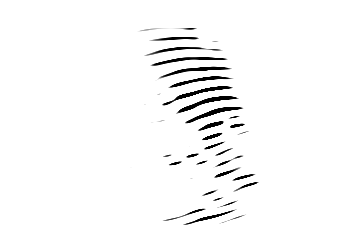

Gabor-filtered image saved to /content/gabor_output_theta_261.png
Gabor Filtered Image (Theta = 262 degrees)


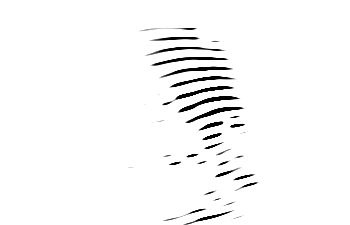

Gabor-filtered image saved to /content/gabor_output_theta_262.png
Gabor Filtered Image (Theta = 263 degrees)


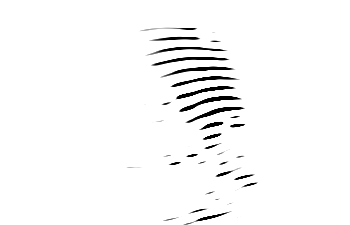

Gabor-filtered image saved to /content/gabor_output_theta_263.png
Gabor Filtered Image (Theta = 264 degrees)


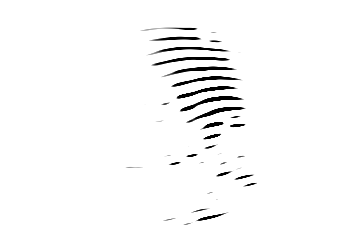

Gabor-filtered image saved to /content/gabor_output_theta_264.png
Gabor Filtered Image (Theta = 265 degrees)


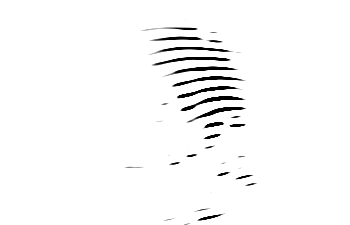

Gabor-filtered image saved to /content/gabor_output_theta_265.png
Gabor Filtered Image (Theta = 266 degrees)


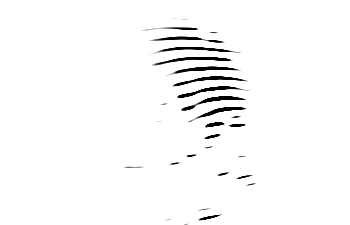

Gabor-filtered image saved to /content/gabor_output_theta_266.png
Gabor Filtered Image (Theta = 267 degrees)


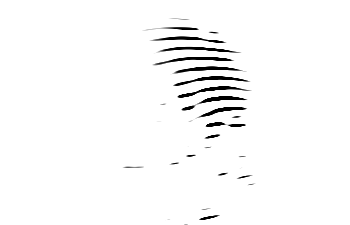

Gabor-filtered image saved to /content/gabor_output_theta_267.png
Gabor Filtered Image (Theta = 268 degrees)


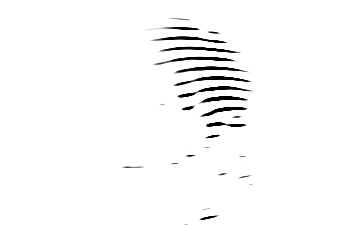

Gabor-filtered image saved to /content/gabor_output_theta_268.png
Gabor Filtered Image (Theta = 269 degrees)


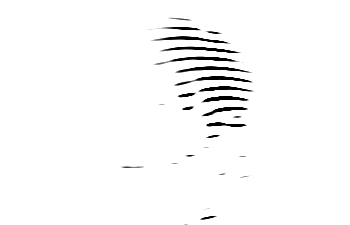

Gabor-filtered image saved to /content/gabor_output_theta_269.png
Gabor Filtered Image (Theta = 270 degrees)


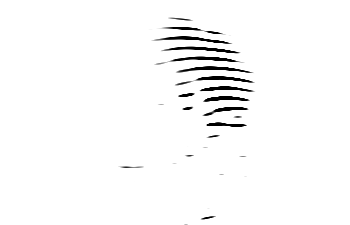

Gabor-filtered image saved to /content/gabor_output_theta_270.png
Gabor Filtered Image (Theta = 271 degrees)


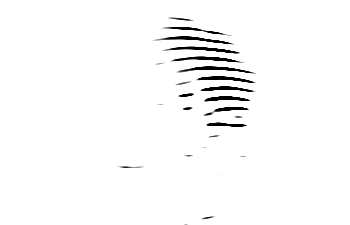

Gabor-filtered image saved to /content/gabor_output_theta_271.png
Gabor Filtered Image (Theta = 272 degrees)


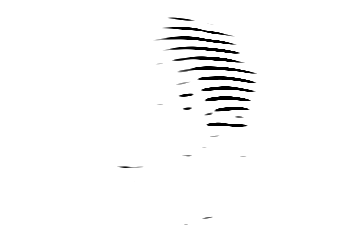

Gabor-filtered image saved to /content/gabor_output_theta_272.png
Gabor Filtered Image (Theta = 273 degrees)


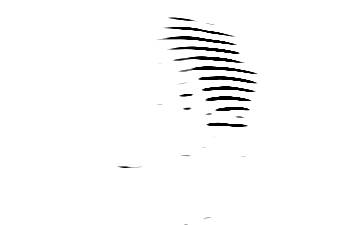

Gabor-filtered image saved to /content/gabor_output_theta_273.png
Gabor Filtered Image (Theta = 274 degrees)


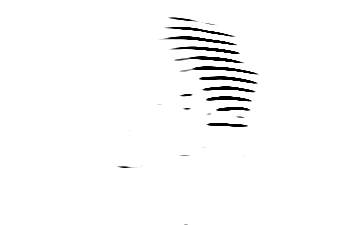

Gabor-filtered image saved to /content/gabor_output_theta_274.png
Gabor Filtered Image (Theta = 275 degrees)


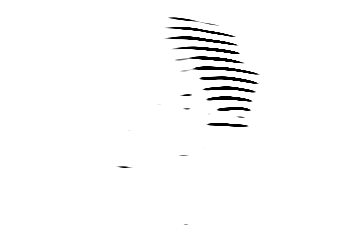

Gabor-filtered image saved to /content/gabor_output_theta_275.png
Gabor Filtered Image (Theta = 276 degrees)


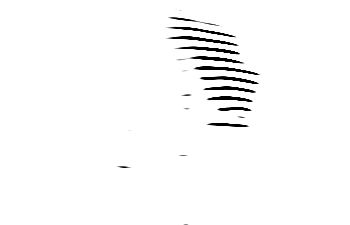

Gabor-filtered image saved to /content/gabor_output_theta_276.png
Gabor Filtered Image (Theta = 277 degrees)


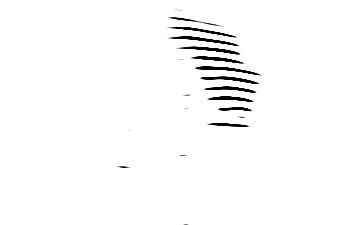

Gabor-filtered image saved to /content/gabor_output_theta_277.png
Gabor Filtered Image (Theta = 278 degrees)


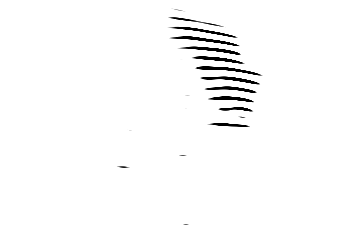

Gabor-filtered image saved to /content/gabor_output_theta_278.png
Gabor Filtered Image (Theta = 279 degrees)


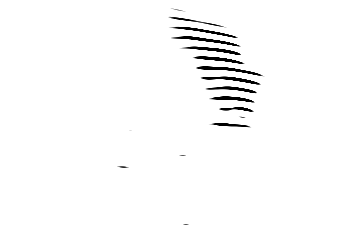

Gabor-filtered image saved to /content/gabor_output_theta_279.png
Gabor Filtered Image (Theta = 280 degrees)


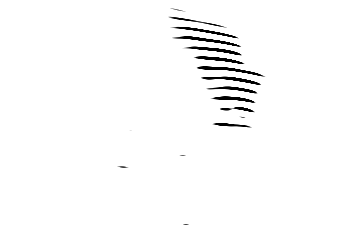

Gabor-filtered image saved to /content/gabor_output_theta_280.png
Gabor Filtered Image (Theta = 281 degrees)


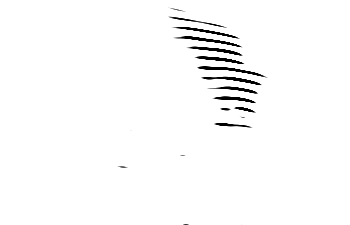

Gabor-filtered image saved to /content/gabor_output_theta_281.png
Gabor Filtered Image (Theta = 282 degrees)


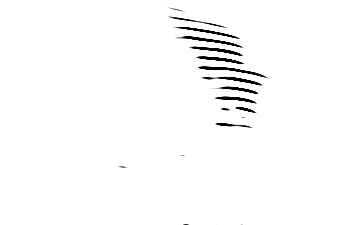

Gabor-filtered image saved to /content/gabor_output_theta_282.png
Gabor Filtered Image (Theta = 283 degrees)


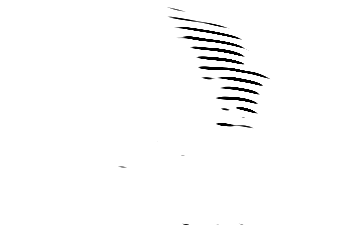

Gabor-filtered image saved to /content/gabor_output_theta_283.png
Gabor Filtered Image (Theta = 284 degrees)


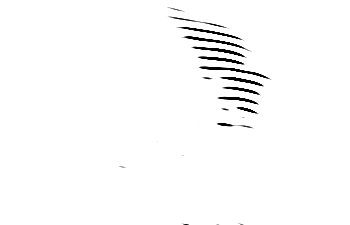

Gabor-filtered image saved to /content/gabor_output_theta_284.png
Gabor Filtered Image (Theta = 285 degrees)


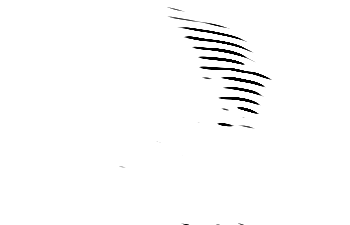

Gabor-filtered image saved to /content/gabor_output_theta_285.png
Gabor Filtered Image (Theta = 286 degrees)


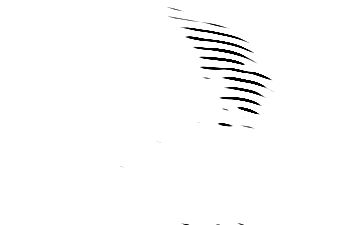

Gabor-filtered image saved to /content/gabor_output_theta_286.png
Gabor Filtered Image (Theta = 287 degrees)


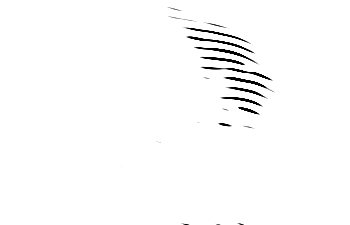

Gabor-filtered image saved to /content/gabor_output_theta_287.png
Gabor Filtered Image (Theta = 288 degrees)


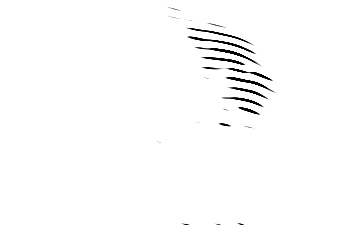

Gabor-filtered image saved to /content/gabor_output_theta_288.png
Gabor Filtered Image (Theta = 289 degrees)


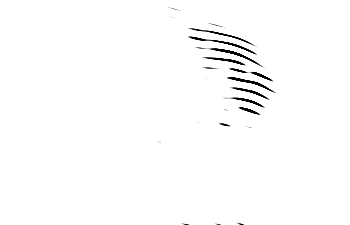

Gabor-filtered image saved to /content/gabor_output_theta_289.png
Gabor Filtered Image (Theta = 290 degrees)


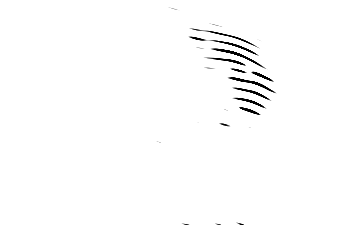

Gabor-filtered image saved to /content/gabor_output_theta_290.png
Gabor Filtered Image (Theta = 291 degrees)


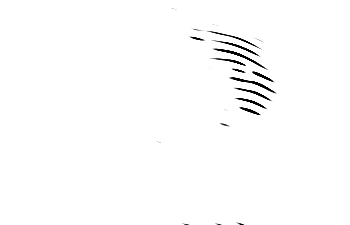

Gabor-filtered image saved to /content/gabor_output_theta_291.png
Gabor Filtered Image (Theta = 292 degrees)


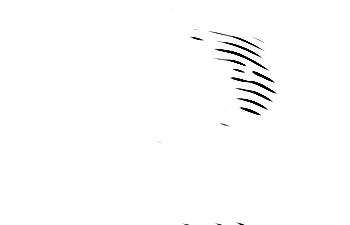

Gabor-filtered image saved to /content/gabor_output_theta_292.png
Gabor Filtered Image (Theta = 293 degrees)


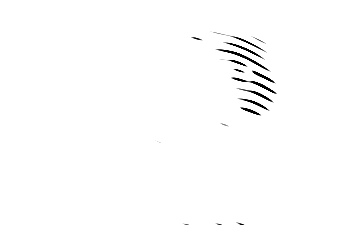

Gabor-filtered image saved to /content/gabor_output_theta_293.png
Gabor Filtered Image (Theta = 294 degrees)


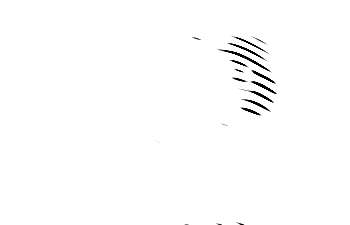

Gabor-filtered image saved to /content/gabor_output_theta_294.png
Gabor Filtered Image (Theta = 295 degrees)


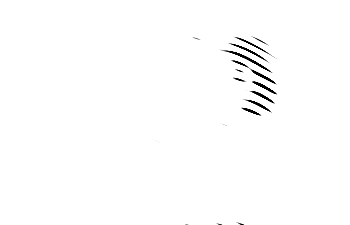

Gabor-filtered image saved to /content/gabor_output_theta_295.png
Gabor Filtered Image (Theta = 296 degrees)


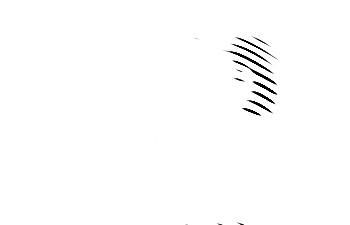

Gabor-filtered image saved to /content/gabor_output_theta_296.png
Gabor Filtered Image (Theta = 297 degrees)


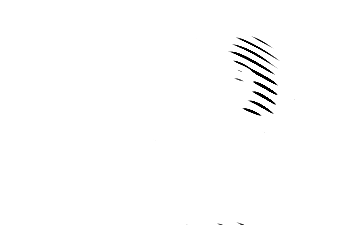

Gabor-filtered image saved to /content/gabor_output_theta_297.png
Gabor Filtered Image (Theta = 298 degrees)


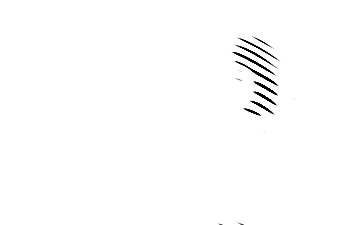

Gabor-filtered image saved to /content/gabor_output_theta_298.png
Gabor Filtered Image (Theta = 299 degrees)


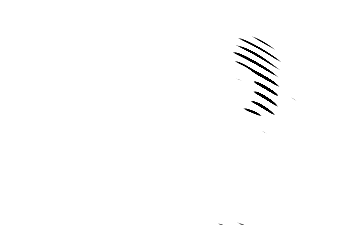

Gabor-filtered image saved to /content/gabor_output_theta_299.png
Gabor Filtered Image (Theta = 300 degrees)


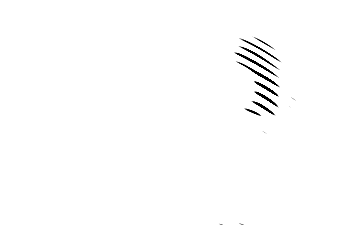

Gabor-filtered image saved to /content/gabor_output_theta_300.png
Gabor Filtered Image (Theta = 301 degrees)


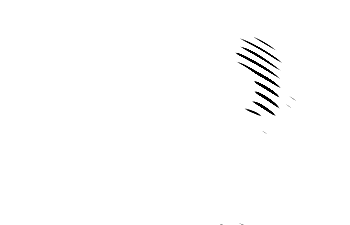

Gabor-filtered image saved to /content/gabor_output_theta_301.png
Gabor Filtered Image (Theta = 302 degrees)


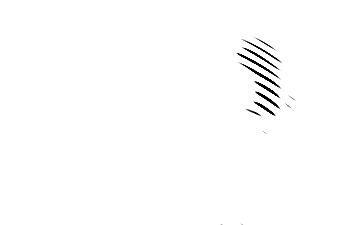

Gabor-filtered image saved to /content/gabor_output_theta_302.png
Gabor Filtered Image (Theta = 303 degrees)


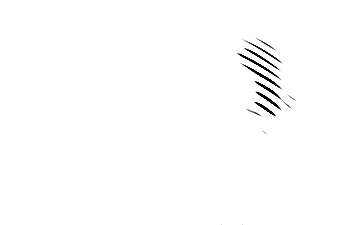

Gabor-filtered image saved to /content/gabor_output_theta_303.png
Gabor Filtered Image (Theta = 304 degrees)


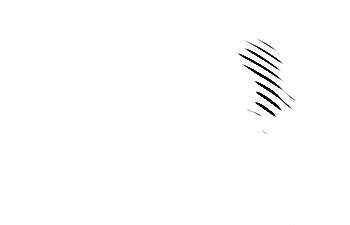

Gabor-filtered image saved to /content/gabor_output_theta_304.png
Gabor Filtered Image (Theta = 305 degrees)


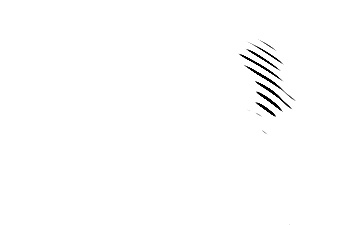

Gabor-filtered image saved to /content/gabor_output_theta_305.png
Gabor Filtered Image (Theta = 306 degrees)


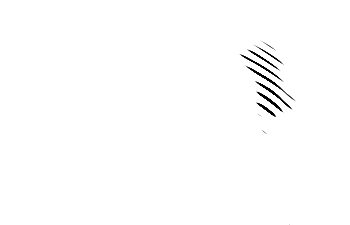

Gabor-filtered image saved to /content/gabor_output_theta_306.png
Gabor Filtered Image (Theta = 307 degrees)


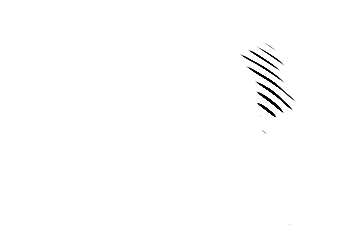

Gabor-filtered image saved to /content/gabor_output_theta_307.png
Gabor Filtered Image (Theta = 308 degrees)


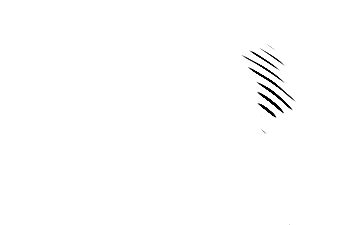

Gabor-filtered image saved to /content/gabor_output_theta_308.png
Gabor Filtered Image (Theta = 309 degrees)


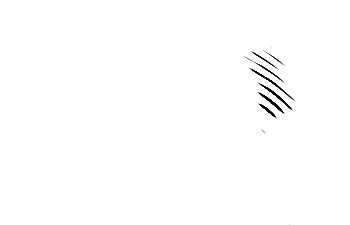

Gabor-filtered image saved to /content/gabor_output_theta_309.png
Gabor Filtered Image (Theta = 310 degrees)


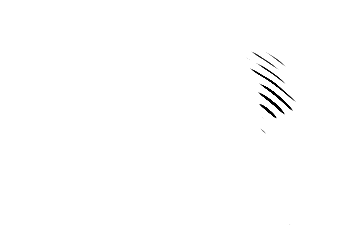

Gabor-filtered image saved to /content/gabor_output_theta_310.png
Gabor Filtered Image (Theta = 311 degrees)


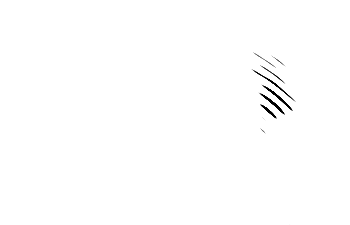

Gabor-filtered image saved to /content/gabor_output_theta_311.png
Gabor Filtered Image (Theta = 312 degrees)


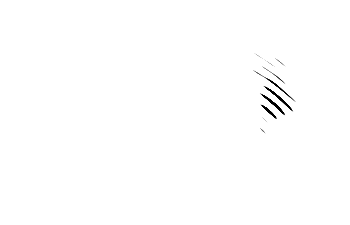

Gabor-filtered image saved to /content/gabor_output_theta_312.png
Gabor Filtered Image (Theta = 313 degrees)


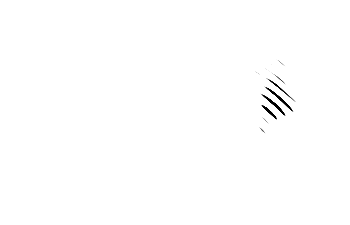

Gabor-filtered image saved to /content/gabor_output_theta_313.png
Gabor Filtered Image (Theta = 314 degrees)


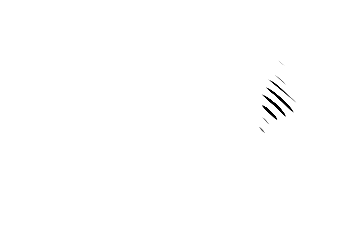

Gabor-filtered image saved to /content/gabor_output_theta_314.png
Gabor Filtered Image (Theta = 315 degrees)


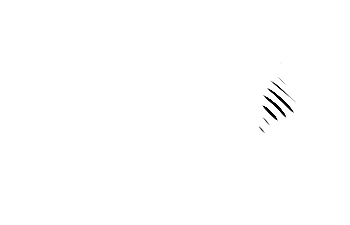

Gabor-filtered image saved to /content/gabor_output_theta_315.png
Gabor Filtered Image (Theta = 316 degrees)


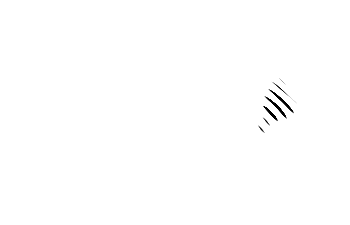

Gabor-filtered image saved to /content/gabor_output_theta_316.png
Gabor Filtered Image (Theta = 317 degrees)


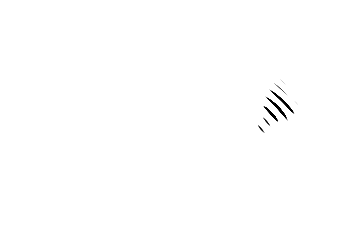

Gabor-filtered image saved to /content/gabor_output_theta_317.png
Gabor Filtered Image (Theta = 318 degrees)


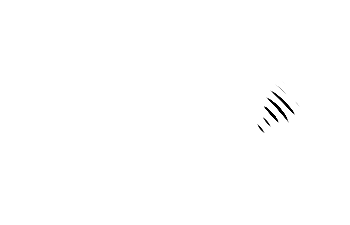

Gabor-filtered image saved to /content/gabor_output_theta_318.png
Gabor Filtered Image (Theta = 319 degrees)


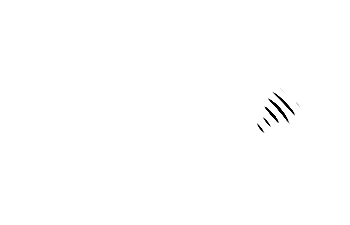

Gabor-filtered image saved to /content/gabor_output_theta_319.png
Gabor Filtered Image (Theta = 320 degrees)


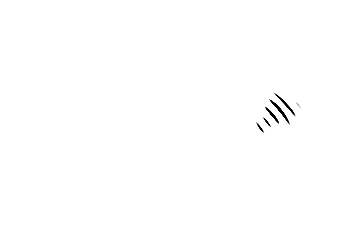

Gabor-filtered image saved to /content/gabor_output_theta_320.png
Gabor Filtered Image (Theta = 321 degrees)


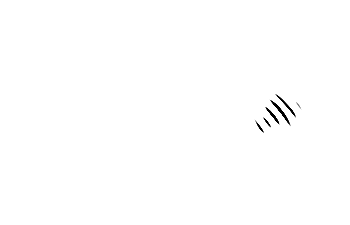

Gabor-filtered image saved to /content/gabor_output_theta_321.png
Gabor Filtered Image (Theta = 322 degrees)


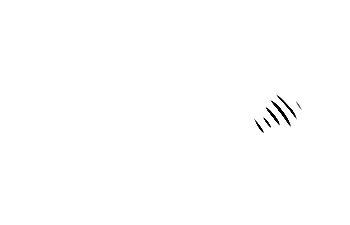

Gabor-filtered image saved to /content/gabor_output_theta_322.png
Gabor Filtered Image (Theta = 323 degrees)


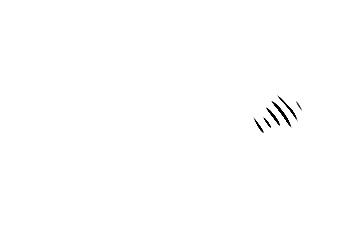

Gabor-filtered image saved to /content/gabor_output_theta_323.png
Gabor Filtered Image (Theta = 324 degrees)


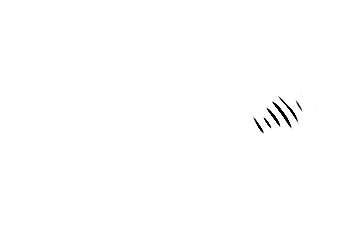

Gabor-filtered image saved to /content/gabor_output_theta_324.png
Gabor Filtered Image (Theta = 325 degrees)


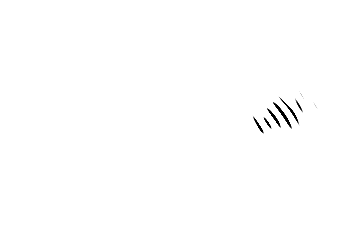

Gabor-filtered image saved to /content/gabor_output_theta_325.png
Gabor Filtered Image (Theta = 326 degrees)


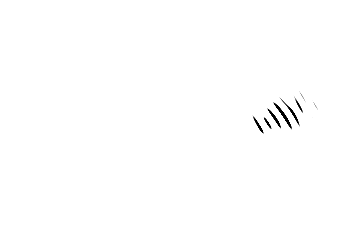

Gabor-filtered image saved to /content/gabor_output_theta_326.png
Gabor Filtered Image (Theta = 327 degrees)


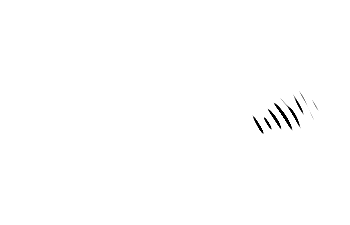

Gabor-filtered image saved to /content/gabor_output_theta_327.png
Gabor Filtered Image (Theta = 328 degrees)


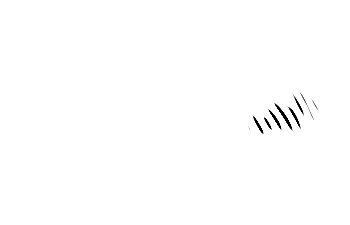

Gabor-filtered image saved to /content/gabor_output_theta_328.png
Gabor Filtered Image (Theta = 329 degrees)


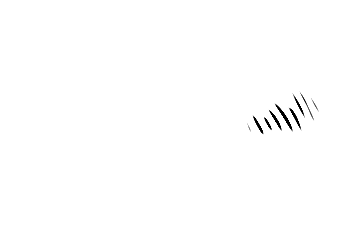

Gabor-filtered image saved to /content/gabor_output_theta_329.png
Gabor Filtered Image (Theta = 330 degrees)


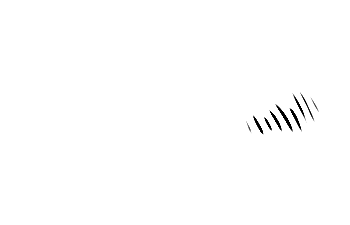

Gabor-filtered image saved to /content/gabor_output_theta_330.png
Gabor Filtered Image (Theta = 331 degrees)


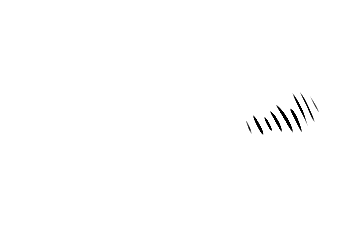

Gabor-filtered image saved to /content/gabor_output_theta_331.png
Gabor Filtered Image (Theta = 332 degrees)


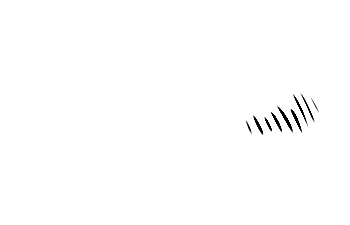

Gabor-filtered image saved to /content/gabor_output_theta_332.png
Gabor Filtered Image (Theta = 333 degrees)


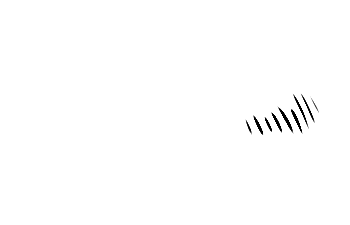

Gabor-filtered image saved to /content/gabor_output_theta_333.png
Gabor Filtered Image (Theta = 334 degrees)


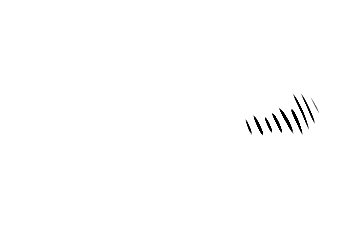

Gabor-filtered image saved to /content/gabor_output_theta_334.png
Gabor Filtered Image (Theta = 335 degrees)


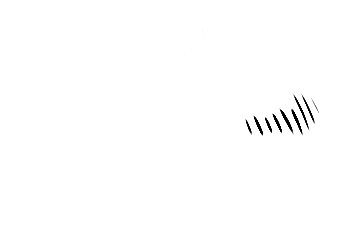

Gabor-filtered image saved to /content/gabor_output_theta_335.png
Gabor Filtered Image (Theta = 336 degrees)


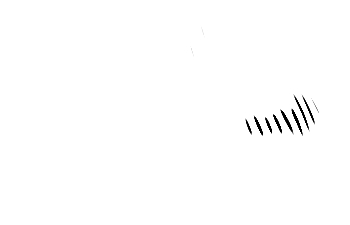

Gabor-filtered image saved to /content/gabor_output_theta_336.png
Gabor Filtered Image (Theta = 337 degrees)


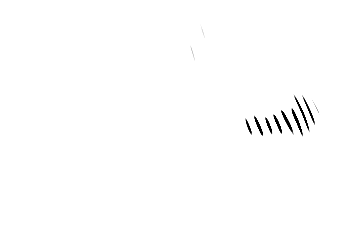

Gabor-filtered image saved to /content/gabor_output_theta_337.png
Gabor Filtered Image (Theta = 338 degrees)


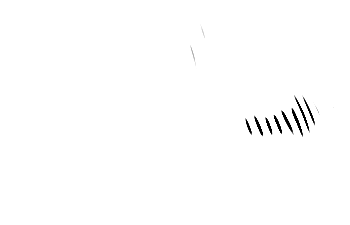

Gabor-filtered image saved to /content/gabor_output_theta_338.png
Gabor Filtered Image (Theta = 339 degrees)


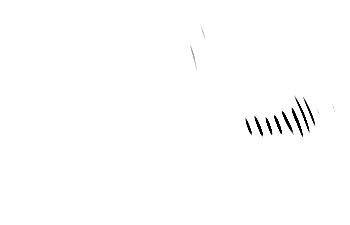

Gabor-filtered image saved to /content/gabor_output_theta_339.png
Gabor Filtered Image (Theta = 340 degrees)


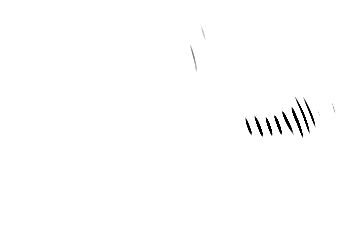

Gabor-filtered image saved to /content/gabor_output_theta_340.png
Gabor Filtered Image (Theta = 341 degrees)


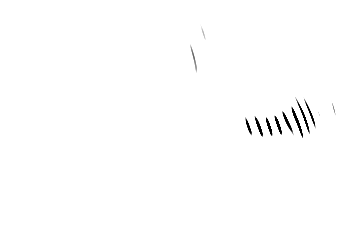

Gabor-filtered image saved to /content/gabor_output_theta_341.png
Gabor Filtered Image (Theta = 342 degrees)


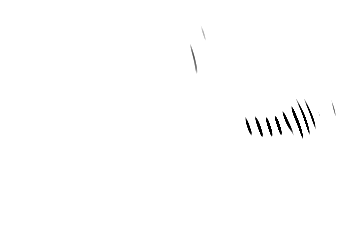

Gabor-filtered image saved to /content/gabor_output_theta_342.png
Gabor Filtered Image (Theta = 343 degrees)


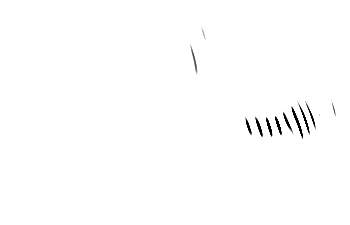

Gabor-filtered image saved to /content/gabor_output_theta_343.png
Gabor Filtered Image (Theta = 344 degrees)


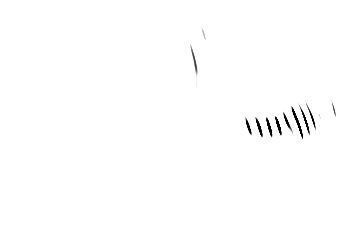

Gabor-filtered image saved to /content/gabor_output_theta_344.png
Gabor Filtered Image (Theta = 345 degrees)


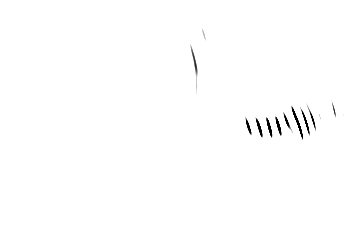

Gabor-filtered image saved to /content/gabor_output_theta_345.png
Gabor Filtered Image (Theta = 346 degrees)


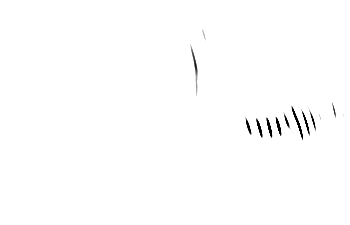

Gabor-filtered image saved to /content/gabor_output_theta_346.png
Gabor Filtered Image (Theta = 347 degrees)


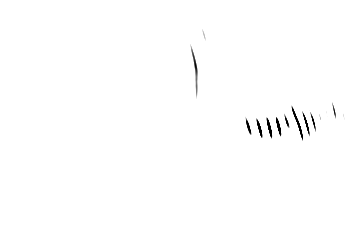

Gabor-filtered image saved to /content/gabor_output_theta_347.png
Gabor Filtered Image (Theta = 348 degrees)


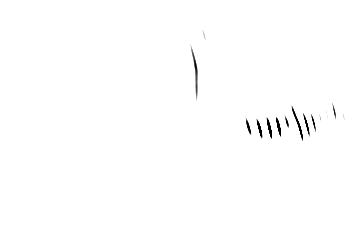

Gabor-filtered image saved to /content/gabor_output_theta_348.png
Gabor Filtered Image (Theta = 349 degrees)


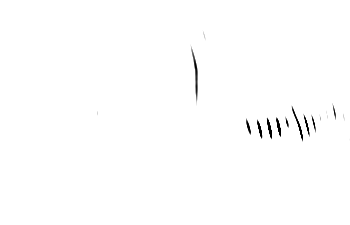

Gabor-filtered image saved to /content/gabor_output_theta_349.png
Gabor Filtered Image (Theta = 350 degrees)


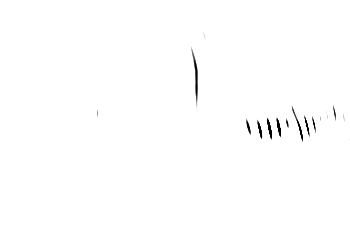

Gabor-filtered image saved to /content/gabor_output_theta_350.png
Gabor Filtered Image (Theta = 351 degrees)


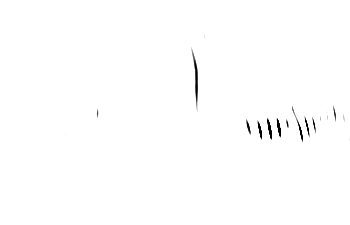

Gabor-filtered image saved to /content/gabor_output_theta_351.png
Gabor Filtered Image (Theta = 352 degrees)


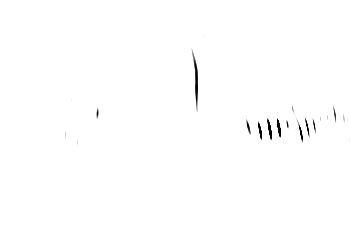

Gabor-filtered image saved to /content/gabor_output_theta_352.png
Gabor Filtered Image (Theta = 353 degrees)


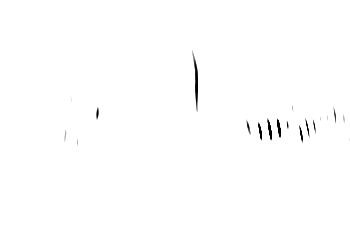

Gabor-filtered image saved to /content/gabor_output_theta_353.png
Gabor Filtered Image (Theta = 354 degrees)


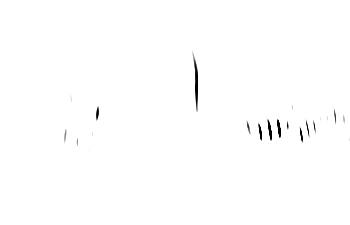

Gabor-filtered image saved to /content/gabor_output_theta_354.png
Gabor Filtered Image (Theta = 355 degrees)


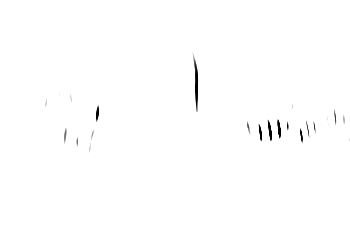

Gabor-filtered image saved to /content/gabor_output_theta_355.png
Gabor Filtered Image (Theta = 356 degrees)


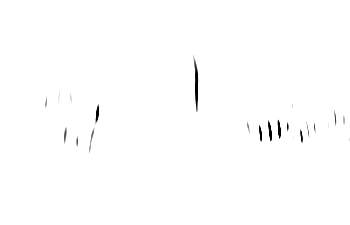

Gabor-filtered image saved to /content/gabor_output_theta_356.png
Gabor Filtered Image (Theta = 357 degrees)


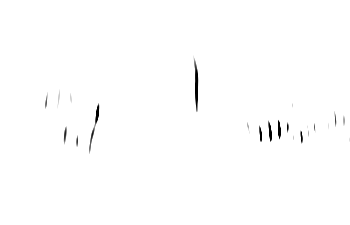

Gabor-filtered image saved to /content/gabor_output_theta_357.png
Gabor Filtered Image (Theta = 358 degrees)


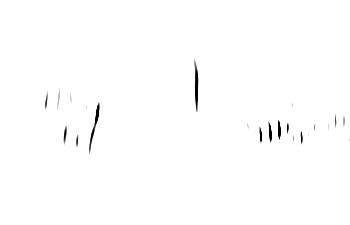

Gabor-filtered image saved to /content/gabor_output_theta_358.png
Gabor Filtered Image (Theta = 359 degrees)


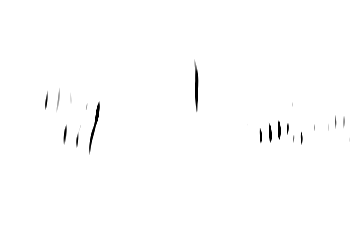

Gabor-filtered image saved to /content/gabor_output_theta_359.png


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Function to create a Gabor filter
def gabor_filter(image, ksize=31, sigma=4.0, theta=0, lambd=10, gamma=0.5):
    # Create Gabor kernel
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)
    # Apply the Gabor filter to the image
    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)
    return filtered_image

# Define the range of orientations (0 to 360 degrees, step of 6 degrees)
orientations = np.arange(0, 360, 1)  # 60 orientations

# Loop through each orientation and apply the Gabor filter
for i, theta_deg in enumerate(orientations):
    # Convert degrees to radians (Gabor filter uses radians)
    theta_rad = np.deg2rad(theta_deg)

    # Apply Gabor filter
    gabor_image = gabor_filter(smoothed_image, theta=theta_rad)

    # Display the Gabor-filtered image
    print(f"Gabor Filtered Image (Theta = {theta_deg} degrees)")
    cv2_imshow(gabor_image)

    # Save the Gabor-filtered image
    gabor_output_path = f'/content/gabor_output_theta_{theta_deg}.png'
    cv2.imwrite(gabor_output_path, gabor_image)
    print(f"Gabor-filtered image saved to {gabor_output_path}")

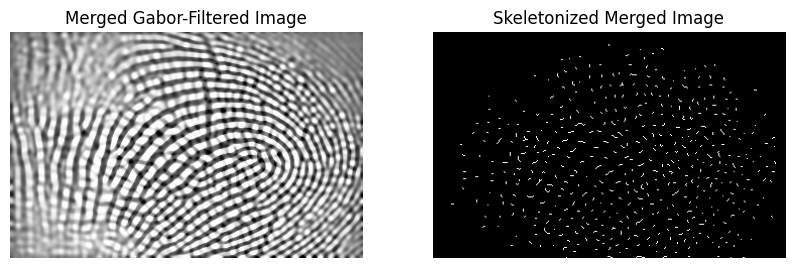

In [ ]:
import cv2
import skimage.morphology
import matplotlib.pyplot as plt

# Ensure the merged_image is in the correct format (grayscale, 8-bit)
merged_image = cv2.normalize(merged_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Step 1: Convert the merged image to binary (0s and 1s) for skeletonization
binary_merged_image = (merged_image // 255).astype(bool)  # Normalize to [0, 1] and convert to boolean

# Step 2: Skeletonize the binary merged image
skeletonized_merged_image = skimage.morphology.skeletonize(binary_merged_image)

# Step 3: Display the original merged image and skeletonized image
plt.figure(figsize=(10, 5))

# Display the original merged image
plt.subplot(1, 2, 1)
plt.imshow(merged_image, cmap='gray')
plt.title("Merged Gabor-Filtered Image")
plt.axis('off')

# Display the skeletonized merged image
plt.subplot(1, 2, 2)
plt.imshow(skeletonized_merged_image, cmap='gray')
plt.title("Skeletonized Merged Image")
plt.axis('off')

plt.show()

Merged Gabor-Filtered Features


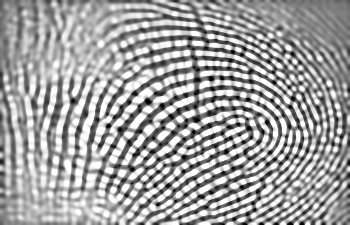

Merged Gabor-filtered features saved to /content/merged_gabor_features.png


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Function to create a Gabor filter
def gabor_filter(image, ksize=31, sigma=4.50, theta=0, lambd=10, gamma=1.5):
    # Create Gabor kernel
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, 0, ktype=cv2.CV_32F)
    # Apply the Gabor filter to the image

    filtered_image = cv2.filter2D(image, cv2.CV_8UC3, kernel)
    return filtered_image

# Define the range of orientations (0 to 360 degrees, step of 6 degrees)
orientations = np.arange(0, 180, 1)  # 60 orientations

# Initialize an empty image to accumulate features
merged_image = np.zeros_like(smoothed_image, dtype=np.float32)

# Loop through each orientation and apply the Gabor filter
for theta_deg in orientations:
    # Convert degrees to radians (Gabor filter uses radians)
    theta_rad = np.deg2rad(theta_deg)

    # Apply Gabor filter
    gabor_image = gabor_filter(smoothed_image, theta=theta_rad)

    # Accumulate the features by adding the Gabor-filtered image
    merged_image += gabor_image.astype(np.float32)

# Normalize the merged image to the range [0, 255]
merged_image = cv2.normalize(merged_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Display the merged image
print("Merged Gabor-Filtered Features")
cv2_imshow(merged_image)

# Save the merged image
merged_output_path = '/content/merged_gabor_features.png'
cv2.imwrite(merged_output_path, merged_image)
print(f"Merged Gabor-filtered features saved to {merged_output_path}")

In [ ]:
pip install fingerprint_enhancer

  Preparing metadata (setup.py) ... done
  Created wheel for fingerprint_enhancer: filename=fingerprint_enhancer-0.0.14-py3-none-any.whl size=10628 sha256=5cf061ffd965a9a16b8d4df8943952d0614d8c3ecd7774a39df2204fd606011a
  Stored in directory: /root/.cache/pip/wheels/3b/de/af/ea18bac41054916ac77ae32dfb8544155d758734b91266315d
Successfully built fingerprint_enhancer


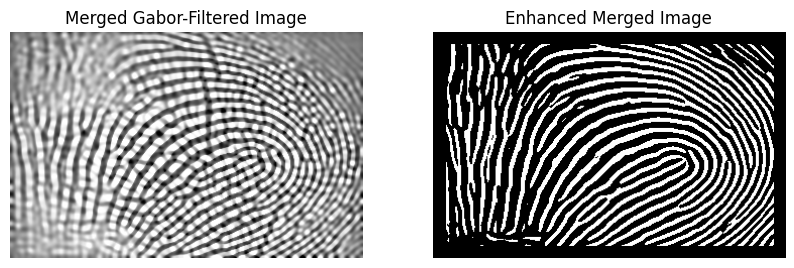

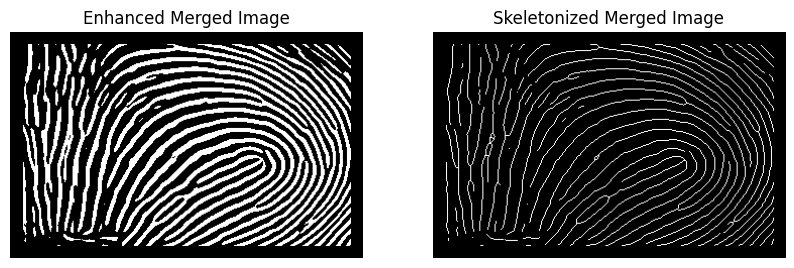

In [ ]:
import fingerprint_enhancer  # Load the library
import cv2
import skimage
import matplotlib.pyplot as plt

# Ensure the merged_image is in the correct format (grayscale, 8-bit)
merged_image = cv2.normalize(merged_image, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

# Step 1: Enhance the merged Gabor-filtered image
enhanced_merged_image = fingerprint_enhancer.enhance_fingerprint(merged_image)

# Step 2: Display the original merged image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(merged_image, cmap='gray')
plt.title("Merged Gabor-Filtered Image")
plt.axis('off')

# Step 3: Display the enhanced merged image
plt.subplot(1, 2, 2)
plt.imshow(enhanced_merged_image, cmap='gray')
plt.title("Enhanced Merged Image")
plt.axis('off')
plt.show()

# Step 4: Skeletonize the enhanced merged image
skeletonized_merged_image = skimage.morphology.skeletonize(enhanced_merged_image)  # Normalize to [0, 1] for skeletonize

# Step 5: Display the skeletonized merged image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(enhanced_merged_image, cmap='gray')
plt.title("Enhanced Merged Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(skeletonized_merged_image, cmap='gray')
plt.title("Skeletonized Merged Image")
plt.axis('off')
plt.show()

<ipython-input-47-17e05ae9e71c>:76: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  self._mask = erosion(self._mask, square(5))


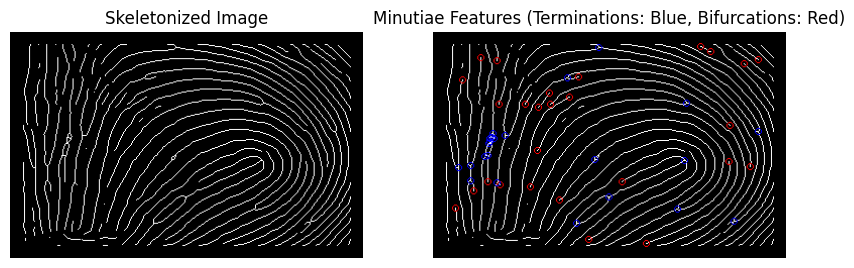

Terminations:
Location: (15, 265), Orientation: [-26.56505117707799]
Location: (20, 275), Orientation: [-180.0]
Location: (26, 47), Orientation: [-90.0]
Location: (28, 322), Orientation: [153.434948822922]
Location: (29, 63), Orientation: [90.0]
Location: (32, 308), Orientation: [-45.0]
Location: (45, 144), Orientation: [-153.434948822922]
Location: (48, 29), Orientation: [-116.56505117707799]
Location: (61, 115), Orientation: [-135.0]
Location: (65, 135), Orientation: [-153.434948822922]
Location: (72, 65), Orientation: [90.0]
Location: (72, 91), Orientation: [63.43494882292201]
Location: (72, 116), Orientation: [26.56505117707799]
Location: (75, 104), Orientation: [45.0]
Location: (93, 294), Orientation: [135.0]
Location: (118, 103), Orientation: [45.0]
Location: (129, 293), Orientation: [-90.0]
Location: (134, 314), Orientation: [90.0]
Location: (149, 54), Orientation: [90.0]
Location: (149, 187), Orientation: [45.0]
Location: (152, 66), Orientation: [135.0]
Location: (154, 96), Ori

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import draw
from skimage.morphology import convex_hull_image, erosion, square
import math

class MinutiaeFeature:
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX
        self.locY = locY
        self.Orientation = Orientation
        self.Type = Type

class FingerprintFeatureExtractor:
    def __init__(self):
        self._mask = []
        self._skel = []
        self.minutiaeTerm = []
        self.minutiaeBif = []
        self._spuriousMinutiaeThresh = 10

    def setSpuriousMinutiaeThresh(self, spuriousMinutiaeThresh):
        self._spuriousMinutiaeThresh = spuriousMinutiaeThresh

    def __skeletonize(self, img):
        img = np.uint8(img > 128)
        self._skel = skimage.morphology.skeletonize(img)
        self._skel = np.uint8(self._skel) * 255
        self._mask = img * 255

    def __computeAngle(self, block, minutiaeType):
        angle = []
        (blkRows, blkCols) = np.shape(block)
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        if minutiaeType.lower() == 'termination':
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
                        if sumVal > 1:
                            angle.append(float('nan'))
            return angle

        elif minutiaeType.lower() == 'bifurcation':
            angle = []
            sumVal = 0
            for i in range(blkRows):
                for j in range(blkCols):
                    if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                        angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                        sumVal += 1
            if sumVal != 3:
                angle.append(float('nan'))
            return angle

    def __getTerminationBifurcation(self):
        self._skel = self._skel == 255
        (rows, cols) = self._skel.shape
        self.minutiaeTerm = np.zeros(self._skel.shape)
        self.minutiaeBif = np.zeros(self._skel.shape)

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                if self._skel[i][j] == 1:
                    block = self._skel[i - 1:i + 2, j - 1:j + 2]
                    block_val = np.sum(block)
                    if block_val == 2:
                        self.minutiaeTerm[i, j] = 1
                    elif block_val == 4:
                        self.minutiaeBif[i, j] = 1

        self._mask = convex_hull_image(self._mask > 0)
        self._mask = erosion(self._mask, square(5))
        self.minutiaeTerm = np.uint8(self._mask) * self.minutiaeTerm

    def __removeSpuriousMinutiae(self, minutiaeList, img):
        img = img * 0
        SpuriousMin = []
        numPoints = len(minutiaeList)
        D = np.zeros((numPoints, numPoints))
        for i in range(1, numPoints):
            for j in range(0, i):
                (X1, Y1) = minutiaeList[i]['centroid']
                (X2, Y2) = minutiaeList[j]['centroid']
                dist = np.sqrt((X2 - X1)**2 + (Y2 - Y1)**2)
                D[i][j] = dist
                if dist < self._spuriousMinutiaeThresh:
                    SpuriousMin.append(i)
                    SpuriousMin.append(j)

        SpuriousMin = np.unique(SpuriousMin)
        for i in range(numPoints):
            if i not in SpuriousMin:
                (X, Y) = np.int16(minutiaeList[i]['centroid'])
                img[X, Y] = 1

        img = np.uint8(img)
        return img

    def __cleanMinutiae(self, img):
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(self.minutiaeTerm)
        self.minutiaeTerm = self.__removeSpuriousMinutiae(RP, np.uint8(img))

    def __performFeatureExtraction(self):
        FeaturesTerm = []
        self.minutiaeTerm = skimage.measure.label(self.minutiaeTerm, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeTerm))

        WindowSize = 2
        for num, i in enumerate(RP):
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Termination')
            if len(angle) == 1:
                FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

        FeaturesBif = []
        self.minutiaeBif = skimage.measure.label(self.minutiaeBif, connectivity=2)
        RP = skimage.measure.regionprops(np.uint8(self.minutiaeBif))
        WindowSize = 1
        for i in RP:
            (row, col) = np.int16(np.round(i['Centroid']))
            block = self._skel[row - WindowSize:row + WindowSize + 1, col - WindowSize:col + WindowSize + 1]
            angle = self.__computeAngle(block, 'Bifurcation')
            if len(angle) == 3:
                FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))
        return FeaturesTerm, FeaturesBif

    def extractMinutiaeFeatures(self, img):
        self.__skeletonize(img)
        self.__getTerminationBifurcation()
        self.__cleanMinutiae(img)
        FeaturesTerm, FeaturesBif = self.__performFeatureExtraction()
        return FeaturesTerm, FeaturesBif


def extract_minutiae_from_skeleton(skeletonized_image, spuriousMinutiaeThresh=10, showResult=True, saveResult=False):
    """
    Extracts minutiae features from a skeletonized fingerprint image.

    Args:
        skeletonized_image (numpy.ndarray): Binary skeletonized image (0s and 1s).
        spuriousMinutiaeThresh (int): Threshold for removing spurious minutiae.
        showResult (bool): Whether to display the result.
        saveResult (bool): Whether to save the result as an image.

    Returns:
        FeaturesTerm (list): List of termination minutiae.
        FeaturesBif (list): List of bifurcation minutiae.
    """
    # Ensure the skeletonized image is binary (0s and 1s)
    skeletonized_image = (skeletonized_image > 0).astype(np.uint8) * 255

    # Initialize the feature extractor
    feature_extractor = FingerprintFeatureExtractor()
    feature_extractor.setSpuriousMinutiaeThresh(spuriousMinutiaeThresh)

    # Extract minutiae features
    FeaturesTerm, FeaturesBif = feature_extractor.extractMinutiaeFeatures(skeletonized_image)

    # Visualize the results
    if showResult:
        (rows, cols) = skeletonized_image.shape
        DispImg = np.zeros((rows, cols, 3), np.uint8)
        DispImg[:, :, 0] = skeletonized_image
        DispImg[:, :, 1] = skeletonized_image
        DispImg[:, :, 2] = skeletonized_image

        # Mark terminations in blue
        for term in FeaturesTerm:
            row, col = term.locX, term.locY
            rr, cc = draw.circle_perimeter(row, col, 3)
            DispImg[rr, cc] = [255, 0, 0]  # Blue for terminations

        # Mark bifurcations in red
        for bif in FeaturesBif:
            row, col = bif.locX, bif.locY
            rr, cc = draw.circle_perimeter(row, col, 3)
            DispImg[rr, cc] = [0, 0, 255]  # Red for bifurcations

        # Display the result
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(skeletonized_image, cmap='gray')
        plt.title("Skeletonized Image")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(DispImg)
        plt.title("Minutiae Features (Terminations: Blue, Bifurcations: Red)")
        plt.axis('off')

        plt.show()

    # Save the result
    if saveResult:
        cv2.imwrite('minutiae_result.png', DispImg)

    return FeaturesTerm, FeaturesBif


# Example usage
if __name__ == "__main__":
    # Use the skeletonized image from the previous code
    skeletonized_image = skeletonized_merged_image  # From the previous code

    # Ensure the skeletonized image is binary (0s and 1s)
    skeletonized_image = (skeletonized_image > 0).astype(np.uint8) * 255

    # Extract minutiae features
    FeaturesTerm, FeaturesBif = extract_minutiae_from_skeleton(
        skeletonized_image,
        spuriousMinutiaeThresh=10,
        showResult=True,
        saveResult=True
    )

    # Print the extracted features
    print("Terminations:")
    for term in FeaturesTerm:
        print(f"Location: ({term.locX}, {term.locY}), Orientation: {term.Orientation}")

    print("\nBifurcations:")
    for bif in FeaturesBif:
        print(f"Location: ({bif.locX}, {bif.locY}), Orientation: {bif.Orientation}")

In [ ]:
from google.colab.patches import cv2_imshow

For example, here we download and display a PNG image of the Colab logo: